In [13]:
import numpy as np
import torch
from collections import defaultdict
from scipy.spatial.distance import jensenshannon
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import itertools

import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import sys
sys.path.append("../2_train_models")
from file_configs import FoldFilesConfig, MergedFilesConfig
from data_loading import extract_observed_profiles

from common_functions import load_coords
from plot_utils import jitter_dots

## Data Loading

In [3]:
# all sets of models we trained, based on available ENCODE data
cell_types = ["K562", "A673", "CACO2", "CALU3", "HUVEC", "MCF10A"]

# the unique IDs for each of the folds / models in each cell type
timestamps = {"K562" : ["2023-05-29_15-51-40", "2023-05-29_15-58-41", "2023-05-29_15-59-09",
                        "2023-05-30_01-40-06", "2023-05-29_23-21-23", "2023-05-29_23-23-45",
                        "2023-05-29_23-24-11"],
              "A673" : ["2023-06-11_20-11-32","2023-06-11_23-42-00", "2023-06-12_03-29-06",
                        "2023-06-12_07-17-43", "2023-06-12_11-10-59", "2023-06-12_14-36-40",
                        "2023-06-12_17-26-09"],
              "CACO2" : ["2023-06-12_21-46-40", "2023-06-13_01-28-24", "2023-06-13_05-06-53",
                         "2023-06-13_08-52-39", "2023-06-13_13-12-09", "2023-06-13_16-40-41",
                         "2023-06-13_20-08-39"],
              "CALU3" : ["2023-06-14_00-43-44", "2023-06-14_04-26-48", "2023-06-14_09-34-26",
                         "2023-06-14_13-03-59", "2023-06-14_17-22-28", "2023-06-14_21-03-11",
                         "2023-06-14_23-58-36"],
              "HUVEC" : ["2023-06-16_21-59-35", "2023-06-17_00-20-34", "2023-06-17_02-17-07",
                         "2023-06-17_04-27-08", "2023-06-17_06-42-19", "2023-06-17_09-16-24",
                         "2023-06-17_11-09-38"],
              "MCF10A" : ["2023-06-15_06-07-40", "2023-06-15_10-37-03", "2023-06-15_16-23-56",
                          "2023-06-15_21-44-32", "2023-06-16_03-47-46", "2023-06-16_09-41-26",
                          "2023-06-16_15-07-01"]}

# these usually don't change
model_type = "strand_merged_umap"
data_type = "procap"

# size of the model inputs and outputs
in_window = 2114
out_window = 1000

In [8]:
# these paths aren't specific to any model / fold, cell type, or data_type

any_config = MergedFilesConfig(cell_types[0], model_type, data_type)
proj_dir = any_config.proj_dir
genome_path = any_config.genome_path
chrom_sizes = any_config.chrom_sizes

figures_dir = proj_dir + "figures/"
os.makedirs(figures_dir, exist_ok=True)

union_peaks_path = proj_dir + "data/" + data_type + "/processed/union_peaks.bed.gz"

In [5]:
def get_pseudorep_filepaths(pseudorep, pos_or_neg, data_dir):
    # Get paths to bigwigs for the pseudoreplicates of an experiment
    #  - pseudorep should be either an int (1-indexed) or an integer string
    
    assert pos_or_neg in ["pos", "neg"], pos_or_neg
    return os.path.join(data_dir, "pseudorep" + str(pseudorep) + "." + pos_or_neg + ".bigWig")


def load_pseudoreplicate_profiles(pseudorep, peaks_path, data_dir, out_window=out_window):
    pos_bw_path = get_pseudorep_filepaths(pseudorep, "pos", data_dir)
    neg_bw_path = get_pseudorep_filepaths(pseudorep, "neg", data_dir)
    
    profs = extract_observed_profiles(pos_bw_path, neg_bw_path, peaks_path,
                                      out_window=out_window, verbose=True)
    return profs


def get_replicate_filepaths(rep, pos_or_neg, data_dir):
    # Get paths to bigwigs for the replicates of an experiment
    #  - rep should be either an int (1-indexed) or an integer string
    
    assert pos_or_neg in ["pos", "neg"], pos_or_neg
    return os.path.join(data_dir, "rep" + str(rep) + ".5prime." + pos_or_neg + ".bigWig")


def load_replicate_profiles(rep, peaks_path, data_dir, out_window=out_window):
    pos_bw_path = get_replicate_filepaths(rep, "pos", data_dir)
    neg_bw_path = get_replicate_filepaths(rep, "neg", data_dir)
    
    profs = extract_observed_profiles(pos_bw_path, neg_bw_path, peaks_path,
                                      out_window=out_window, verbose=True)
    return profs

In [6]:
def get_sort_order_test_sets(merged_config, fold_configs, in_window=in_window):
    # Each model / fold has a mutually exclusive test set; the order of the examples
    # in each test set differs from the order in the merged file of all examples.
    # So, this function figures out how to reorder the test set model predictions
    # so that they can be compared to the observed data.
    
    # First, load in the test set coordinates for each fold's test set
    
    test_coords = []
    for config in fold_configs:
        test_coords.extend(load_coords(config.test_peak_path, in_window))
        
    # Second, load in the test set coordinates for the merged file
    # (the "correct order")
    
    all_coords = load_coords(merged_config.all_peak_path, in_window)
    
    # Third, figure out the re-ordering needed to arrange the test coords
    # so they match the ordering in the merged file.
    # (then use that ordering later to fix the order of model predictions)
    
    sort_order = [test_coords.index(coord) for coord in all_coords]
    assert np.all(np.array(all_coords) == np.array(test_coords)[sort_order])
    
    return sort_order


# Load the config objects (filepaths holders) for each fold a model was trained on

def load_fold_configs(cell_type, timestamps,
                      model_type = model_type, data_type = data_type):

    fold_configs = []
    for fold_i, timestamp in enumerate(timestamps):
        # folds are 1-indexed, and config constructor is expecting a string
        fold = str(fold_i + 1)
        
        # load the config object for this specific fold / model
        config = FoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
        fold_configs.append(config)
        
    return fold_configs

In [7]:
def load_test_data(merged_config, fold_configs):
    true_profs = []
    true_counts = []
    pseudorep1_profs = []
    pseudorep2_profs = []
    rep1_profs = []
    rep2_profs = []
    log_pred_profs = []
    pred_logcounts = []
    
    for config in fold_configs:
        # Load observed data: replicate-merged PRO-cap signal
        obs_profs = extract_observed_profiles(config.plus_bw_path,
                                              config.minus_bw_path,
                                              config.test_peak_path,
                                              out_window=out_window,
                                              verbose=True)
        true_profs.extend(obs_profs)
        true_counts.extend(obs_profs.sum(axis=-1).squeeze())

        # Load PRO-cap signal for each pseudoreplicate individually (to see reproducibility)
        pseudorep1_profs.extend(load_pseudoreplicate_profiles(1, config.test_peak_path, config.data_dir))
        pseudorep2_profs.extend(load_pseudoreplicate_profiles(2, config.test_peak_path, config.data_dir))
        
        # Load PRO-cap signal for each replicate individually (also to see reproducibility)
        rep1_profs.extend(load_replicate_profiles(1, config.test_peak_path, config.data_dir))
        rep2_profs.extend(load_replicate_profiles(2, config.test_peak_path, config.data_dir))

        # Load model predictions
        log_pred_profs.extend(np.load(config.pred_profiles_test_path))
        pred_logcounts.extend(np.load(config.pred_logcounts_test_path).squeeze())
        
        # everything above should have loaded in the same number of examples/loci
        
        assert len(true_profs) == len(true_counts)
        assert len(pseudorep1_profs) == len(pseudorep2_profs)
        assert len(rep1_profs) == len(rep2_profs)
        assert len(pseudorep1_profs) == len(rep1_profs)
        assert len(pseudorep1_profs) == len(true_counts)
        assert len(log_pred_profs) == len(pred_logcounts)
        assert len(pred_logcounts) == len(true_counts)
        
    sort_order = get_sort_order_test_sets(merged_config, fold_configs)
    
    true_profs = np.array(true_profs)[sort_order]
    true_counts = np.array(true_counts)[sort_order]
    pseudorep1_profs = np.array(pseudorep1_profs)[sort_order]
    pseudorep2_profs = np.array(pseudorep2_profs)[sort_order]
    rep1_profs = np.array(rep1_profs)[sort_order]
    rep2_profs = np.array(rep2_profs)[sort_order]
    log_pred_profs = np.array(log_pred_profs)[sort_order]
    pred_logcounts = np.array(pred_logcounts)[sort_order]
    
    pred_profs = np.exp(log_pred_profs)
    
    return true_profs, true_counts, pseudorep1_profs, pseudorep2_profs, rep1_profs, rep2_profs, pred_profs, pred_logcounts


def load_test_data_all_cells(cell_types, timestamps, model_type = model_type, data_type = data_type):
    true_profs = dict()
    true_counts = dict()
    pseudorep1_profs = dict()
    pseudorep2_profs = dict()
    pred_profs = dict()
    pred_logcounts = dict()
    
    for cell_type in cell_types:
        merged_config = MergedFilesConfig(cell_type, model_type, data_type)
        fold_configs = load_fold_configs(cell_type, timestamps[cell_type])
        
        test_data = load_test_data(merged_config, fold_configs)
        
        # unpack large tuple of data that was returned by function above
        
        true_profs[cell_type] = test_data[0]
        true_counts[cell_type] = test_data[1]
        pseudorep1_profs[cell_type] = test_data[2]
        pseudorep2_profs[cell_type] = test_data[3]
        # skipping replicates because we don't actually use that anywhere
        pred_profs[cell_type] = test_data[6]
        pred_logcounts[cell_type] = test_data[7]
    
    return true_profs, true_counts, pseudorep1_profs, pseudorep2_profs, pred_profs, pred_logcounts


true_profs, true_counts, pseudorep1_profs, pseudorep2_profs, \
        pred_profs, pred_logcounts = load_test_data_all_cells(cell_types, timestamps)

Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11


Loading Profiles: 4334it [00:01, 3951.65it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334


Loading Profiles: 4334it [00:01, 2604.70it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334


Loading Profiles: 4334it [00:01, 2473.27it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334



Loading Profiles: 4334it [00:01, 3026.71it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334



Loading Profiles: 4334it [00:02, 1979.10it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334



Loading Profiles: 3699it [00:00, 3997.93it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699



Loading Profiles: 3699it [00:01, 3173.20it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699



Loading Profiles: 3699it [00:01, 2711.29it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699


Loading Profiles: 3699it [00:01, 3623.04it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699



Loading Profiles: 3699it [00:01, 3052.43it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699



Loading Profiles: 4559it [00:01, 4074.24it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 4559it [00:01, 3400.60it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 4559it [00:01, 3541.46it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559


Loading Profiles: 4559it [00:01, 3897.38it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 4559it [00:01, 3342.36it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 3887it [00:00, 4058.37it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 3887it [00:01, 3368.20it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 3887it [00:01, 2718.93it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 3887it [00:01, 3885.29it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887


Loading Profiles: 3887it [00:01, 2857.96it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 4470it [00:01, 4063.68it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470


Loading Profiles: 4470it [00:01, 3459.49it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470


Loading Profiles: 4470it [00:01, 3470.99it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470



Loading Profiles: 4470it [00:01, 3532.57it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470



Loading Profiles: 4470it [00:01, 3154.68it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470



Loading Profiles: 5238it [00:01, 4003.02it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238


Loading Profiles: 5238it [00:01, 3320.34it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238



Loading Profiles: 5238it [00:01, 3378.04it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238



Loading Profiles: 5238it [00:01, 3967.87it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238



Loading Profiles: 5238it [00:01, 3058.25it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238



Loading Profiles: 4347it [00:01, 4075.28it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347



Loading Profiles: 4347it [00:01, 3392.31it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347



Loading Profiles: 4347it [00:01, 3812.88it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347



Loading Profiles: 4347it [00:01, 4072.83it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347



Loading Profiles: 4347it [00:01, 3515.85it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347


Timestamp: 2023-06-11_20-11-32
Timestamp: 2023-06-11_23-42-00
Timestamp: 2023-06-12_03-29-06
Timestamp: 2023-06-12_07-17-43
Timestamp: 2023-06-12_11-10-59
Timestamp: 2023-06-12_14-36-40
Timestamp: 2023-06-12_17-26-09


Loading Profiles: 7090it [00:02, 2747.24it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 7090



Loading Profiles: 7090it [00:02, 3027.55it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 7090



Loading Profiles: 7090it [00:02, 3107.27it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 7090



Loading Profiles: 7090it [00:02, 3318.92it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 7090


Loading Profiles: 7090it [00:02, 3074.90it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 7090



Loading Profiles: 7037it [00:02, 2982.49it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 7037



Loading Profiles: 7037it [00:02, 3069.18it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 7037



Loading Profiles: 7037it [00:02, 3050.13it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 7037



Loading Profiles: 7037it [00:02, 3434.44it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 7037



Loading Profiles: 7037it [00:02, 3171.64it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 7037


Loading Profiles: 7515it [00:02, 3336.27it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7515



Loading Profiles: 7515it [00:02, 3479.63it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7515



Loading Profiles: 7515it [00:02, 3661.32it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7515



Loading Profiles: 7515it [00:01, 3995.27it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7515



Loading Profiles: 7515it [00:01, 3952.72it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7515


Loading Profiles: 6473it [00:02, 3017.39it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 6473



Loading Profiles: 6473it [00:01, 3664.07it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 6473



Loading Profiles: 6473it [00:01, 3514.58it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 6473



Loading Profiles: 6473it [00:01, 3990.93it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 6473



Loading Profiles: 6473it [00:02, 3184.05it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 6473


Loading Profiles: 7960it [00:02, 2874.35it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 7960


Loading Profiles: 7960it [00:02, 3070.67it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 7960



Loading Profiles: 7960it [00:02, 3219.64it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 7960



Loading Profiles: 7960it [00:02, 3246.97it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 7960



Loading Profiles: 7960it [00:02, 3213.07it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 7960



Loading Profiles: 8865it [00:02, 3153.97it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8865


Loading Profiles: 8865it [00:02, 3418.69it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8865



Loading Profiles: 8865it [00:02, 3467.92it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8865



Loading Profiles: 8865it [00:02, 3679.25it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8865


Loading Profiles: 8865it [00:02, 3655.21it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8865



Loading Profiles: 6300it [00:01, 3252.27it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6300



Loading Profiles: 6300it [00:01, 3696.17it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6300


Loading Profiles: 6300it [00:01, 3564.46it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6300



Loading Profiles: 6300it [00:01, 4149.11it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6300



Loading Profiles: 6300it [00:01, 3932.86it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/A673/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6300
Timestamp: 2023-06-12_21-46-40
Timestamp: 2023-06-13_01-28-24
Timestamp: 2023-06-13_05-06-53
Timestamp: 2023-06-13_08-52-39
Timestamp: 2023-06-13_13-12-09
Timestamp: 2023-06-13_16-40-41
Timestamp: 2023-06-13_20-08-39


Loading Profiles: 6230it [00:02, 2970.14it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 6230



Loading Profiles: 6230it [00:01, 3447.21it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 6230



Loading Profiles: 6230it [00:01, 3925.56it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 6230



Loading Profiles: 6230it [00:02, 3105.87it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 6230



Loading Profiles: 6230it [00:01, 3157.51it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 6230



Loading Profiles: 6460it [00:02, 2387.30it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 6460



Loading Profiles: 6460it [00:02, 3168.82it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 6460



Loading Profiles: 6460it [00:01, 3243.81it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 6460


Loading Profiles: 6460it [00:02, 3229.73it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 6460


Loading Profiles: 6460it [00:02, 3109.58it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 6460



Loading Profiles: 7089it [00:02, 3090.62it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7089



Loading Profiles: 7089it [00:01, 3644.18it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7089


Loading Profiles: 7089it [00:02, 3305.17it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7089



Loading Profiles: 7089it [00:01, 3564.79it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7089


Loading Profiles: 7089it [00:01, 3785.80it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7089



Loading Profiles: 5874it [00:01, 3218.95it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 5874



Loading Profiles: 5874it [00:01, 3494.01it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 5874



Loading Profiles: 5874it [00:01, 3353.65it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 5874



Loading Profiles: 5874it [00:01, 3524.64it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 5874



Loading Profiles: 5874it [00:01, 3204.69it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 5874


Loading Profiles: 7963it [00:02, 3018.42it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 7963



Loading Profiles: 7963it [00:02, 3066.59it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 7963



Loading Profiles: 7963it [00:02, 3719.92it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 7963



Loading Profiles: 7963it [00:02, 3045.94it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 7963


Loading Profiles: 7963it [00:02, 3319.38it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 7963


Loading Profiles: 8549it [00:02, 3087.58it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8549



Loading Profiles: 8549it [00:02, 3448.09it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8549


Loading Profiles: 8549it [00:02, 3547.88it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8549


Loading Profiles: 8549it [00:02, 3344.32it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8549


Loading Profiles: 8549it [00:02, 3499.80it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8549



Loading Profiles: 6042it [00:01, 3486.20it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6042



Loading Profiles: 6042it [00:01, 3801.30it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6042


Loading Profiles: 6042it [00:01, 3744.31it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6042



Loading Profiles: 6042it [00:01, 3959.66it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6042



Loading Profiles: 6042it [00:01, 3859.87it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CACO2/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6042


Timestamp: 2023-06-14_00-43-44
Timestamp: 2023-06-14_04-26-48
Timestamp: 2023-06-14_09-34-26
Timestamp: 2023-06-14_13-03-59
Timestamp: 2023-06-14_17-22-28
Timestamp: 2023-06-14_21-03-11
Timestamp: 2023-06-14_23-58-36


Loading Profiles: 6601it [00:02, 2821.26it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 6601



Loading Profiles: 6601it [00:02, 3108.45it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 6601



Loading Profiles: 6601it [00:01, 3589.13it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 6601



Loading Profiles: 6601it [00:01, 3624.29it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 6601



Loading Profiles: 6601it [00:01, 3497.75it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 6601



Loading Profiles: 6247it [00:02, 2314.37it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 6247


Loading Profiles: 6247it [00:02, 2890.99it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 6247



Loading Profiles: 6247it [00:01, 3242.78it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 6247



Loading Profiles: 6247it [00:02, 2973.73it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 6247



Loading Profiles: 6247it [00:02, 2617.66it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 6247


Loading Profiles: 7375it [00:02, 3030.47it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7375



Loading Profiles: 7375it [00:02, 3500.10it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7375


Loading Profiles: 7375it [00:02, 3614.53it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7375



Loading Profiles: 7375it [00:02, 3658.69it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7375



Loading Profiles: 7375it [00:02, 3327.41it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 7375



Loading Profiles: 6172it [00:01, 3128.47it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 6172



Loading Profiles: 6172it [00:01, 3429.49it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 6172


Loading Profiles: 6172it [00:01, 3490.41it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 6172



Loading Profiles: 6172it [00:01, 3479.09it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 6172


Loading Profiles: 6172it [00:01, 3151.60it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 6172



Loading Profiles: 6865it [00:02, 2592.47it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 6865



Loading Profiles: 6865it [00:02, 3148.61it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 6865



Loading Profiles: 6865it [00:01, 3493.14it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 6865



Loading Profiles: 6865it [00:02, 2955.54it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 6865


Loading Profiles: 6865it [00:02, 2592.03it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 6865


Loading Profiles: 8967it [00:03, 2705.37it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8967



Loading Profiles: 8967it [00:02, 3328.59it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8967


Loading Profiles: 8967it [00:02, 3433.51it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8967


Loading Profiles: 8967it [00:02, 3325.36it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8967


Loading Profiles: 8967it [00:02, 3252.26it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 8967



Loading Profiles: 6092it [00:02, 2902.09it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6092


Loading Profiles: 6092it [00:01, 3692.88it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6092



Loading Profiles: 6092it [00:01, 3631.45it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6092


Loading Profiles: 6092it [00:01, 3553.68it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6092



Loading Profiles: 6092it [00:01, 3382.77it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/CALU3/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6092
Timestamp: 2023-06-16_21-59-35
Timestamp: 2023-06-17_00-20-34
Timestamp: 2023-06-17_02-17-07
Timestamp: 2023-06-17_04-27-08
Timestamp: 2023-06-17_06-42-19
Timestamp: 2023-06-17_09-16-24
Timestamp: 2023-06-17_11-09-38


Loading Profiles: 4122it [00:01, 2266.93it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4122


Loading Profiles: 4122it [00:01, 3069.97it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4122



Loading Profiles: 4122it [00:01, 3645.85it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4122



Loading Profiles: 4122it [00:01, 2935.51it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4122



Loading Profiles: 4122it [00:01, 2972.48it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4122



Loading Profiles: 3783it [00:02, 1715.19it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3783


Loading Profiles: 3783it [00:01, 2462.10it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3783



Loading Profiles: 3783it [00:01, 2960.96it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3783



Loading Profiles: 3783it [00:01, 2600.27it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3783



Loading Profiles: 3783it [00:01, 2137.80it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3783


Loading Profiles: 4128it [00:01, 2908.98it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4128


Loading Profiles: 4128it [00:01, 3079.41it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4128



Loading Profiles: 4128it [00:01, 3058.33it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4128



Loading Profiles: 4128it [00:01, 3651.29it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4128



Loading Profiles: 4128it [00:01, 2874.08it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4128



Loading Profiles: 3727it [00:01, 2518.24it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3727



Loading Profiles: 3727it [00:01, 3467.60it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3727



Loading Profiles: 3727it [00:01, 3354.38it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3727



Loading Profiles: 3727it [00:01, 3305.14it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3727



Loading Profiles: 3727it [00:01, 3221.80it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3727



Loading Profiles: 4324it [00:01, 2579.33it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4324



Loading Profiles: 4324it [00:01, 2968.47it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4324



Loading Profiles: 4324it [00:01, 3096.09it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4324


Loading Profiles: 4324it [00:01, 2978.80it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4324


Loading Profiles: 4324it [00:01, 2624.13it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4324



Loading Profiles: 5335it [00:02, 2623.81it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5335


Loading Profiles: 5335it [00:01, 3147.30it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5335



Loading Profiles: 5335it [00:01, 3456.46it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5335



Loading Profiles: 5335it [00:01, 3591.76it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5335



Loading Profiles: 5335it [00:01, 3228.01it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5335



Loading Profiles: 3721it [00:01, 2198.05it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 3721


Loading Profiles: 3721it [00:01, 3454.56it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 3721



Loading Profiles: 3721it [00:01, 3529.14it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 3721



Loading Profiles: 3721it [00:01, 3631.34it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 3721



Loading Profiles: 3721it [00:01, 3448.22it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/HUVEC/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 3721


Timestamp: 2023-06-15_06-07-40
Timestamp: 2023-06-15_10-37-03
Timestamp: 2023-06-15_16-23-56
Timestamp: 2023-06-15_21-44-32
Timestamp: 2023-06-16_03-47-46
Timestamp: 2023-06-16_09-41-26
Timestamp: 2023-06-16_15-07-01


Loading Profiles: 8954it [00:03, 2279.78it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 8954



Loading Profiles: 8954it [00:03, 2869.40it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 8954


Loading Profiles: 8954it [00:03, 2575.95it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 8954



Loading Profiles: 8954it [00:03, 2771.59it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 8954



Loading Profiles: 8954it [00:02, 3359.77it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 8954



Loading Profiles: 7729it [00:03, 2491.78it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 7729



Loading Profiles: 7729it [00:02, 2797.05it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 7729



Loading Profiles: 7729it [00:02, 3014.32it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 7729



Loading Profiles: 7729it [00:02, 2793.55it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 7729



Loading Profiles: 7729it [00:02, 2972.40it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 7729


Loading Profiles: 8928it [00:03, 2562.10it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 8928



Loading Profiles: 8928it [00:03, 2928.88it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 8928


Loading Profiles: 8928it [00:03, 2846.36it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 8928



Loading Profiles: 8928it [00:02, 3051.94it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 8928



Loading Profiles: 8928it [00:02, 3703.36it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 8928


Loading Profiles: 7662it [00:03, 2526.54it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 7662



Loading Profiles: 7662it [00:02, 3065.10it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 7662



Loading Profiles: 7662it [00:02, 2944.29it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 7662



Loading Profiles: 7662it [00:02, 3442.19it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 7662



Loading Profiles: 7662it [00:02, 3724.78it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 7662



Loading Profiles: 8685it [00:03, 2682.79it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 8685



Loading Profiles: 8685it [00:03, 2738.34it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 8685


Loading Profiles: 8685it [00:02, 2926.09it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 8685



Loading Profiles: 8685it [00:03, 2814.66it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 8685



Loading Profiles: 8685it [00:02, 3248.26it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 8685


Loading Profiles: 10380it [00:03, 2828.11it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 10380



Loading Profiles: 10380it [00:03, 2954.89it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 10380


Loading Profiles: 10380it [00:03, 3235.76it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 10380


Loading Profiles: 10380it [00:03, 3256.66it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 10380



Loading Profiles: 10380it [00:02, 4124.15it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 10380



Loading Profiles: 6883it [00:02, 2594.91it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6883


Loading Profiles: 6883it [00:02, 3219.04it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6883


Loading Profiles: 6883it [00:02, 3250.51it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6883



Loading Profiles: 6883it [00:02, 2971.32it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6883



Loading Profiles: 6883it [00:02, 3411.57it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/MCF10A/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 6883


## Model Performance: Fig. 8A

### Counts Task

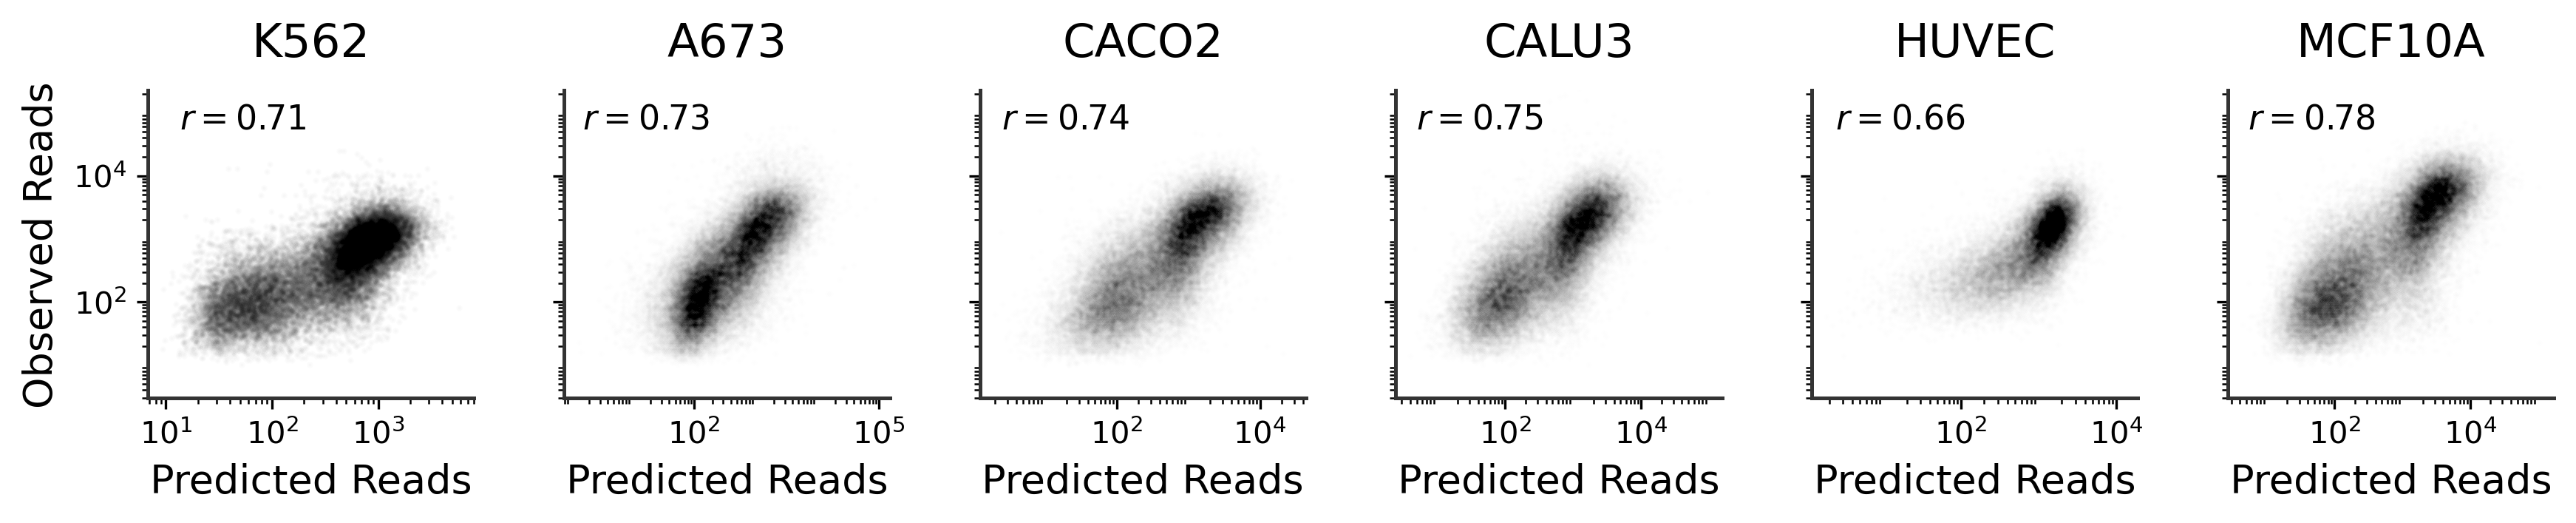

In [22]:
def plot_pred_vs_true_counts_all_cells(all_pred_logcounts,
                                       all_true_counts, cell_types,
                                       save_path=None):
    
    fig, axes = plt.subplots(1, len(cell_types),
                             figsize=(14, 1.8), dpi=300, sharey=True)

    max_y_ever = 0
    for ax, cell_type in zip(axes, cell_types):
        pred_logcounts = all_pred_logcounts[cell_type]
        true_counts = all_true_counts[cell_type]
    
        # calculate max across all cell types to set y-axis later
        max_y_ever = max(max_y_ever, np.max(true_counts))
        
        # if the model preds/data are stranded, merge the two strands
        if len(pred_logcounts.shape) > 1:
            pred_logcounts = np.sum(pred_logcounts, axis=-1)
        if len(true_counts.shape) > 1:
            true_counts = np.sum(true_counts, axis=-1)
        assert pred_logcounts.shape == true_counts.shape

        # it causes pain if the K562 plot looks different from Fig1,
        # but all the other plots look better with changed alpha
        
        if cell_type == "K562":
            ax.scatter(np.exp(pred_logcounts), true_counts,
                        alpha = 0.015, s = 1, color="k")
        else:
            ax.scatter(np.exp(pred_logcounts), true_counts,
                        alpha = 0.005, s = 1, color="k")

        ax.semilogy()
        ax.semilogx()

        ax.set_title(cell_type, fontsize = 15, y=1.05)
        
        ax.set_xlabel("Predicted Reads", fontsize=13)
        
        if cell_type == cell_types[0]:
            ax.set_ylabel("Measured Reads", fontsize=13)
            

        # annotate with pearson corr. text in upper left
        
        pearson_r = np.corrcoef(pred_logcounts,
                                np.log1p(true_counts))[0,1]
        ax.text(ax.get_xlim()[0]*2, 10**5 / 1.8,
                r'$r = %0.2f$' % pearson_r, fontsize=11)

        # aesthetics
        
        ax.spines[["left","bottom"]].set_linewidth(1.2)
        ax.spines[["left","bottom"]].set_color("#333333")
        ax.spines[["top","right"]].set_visible(False)
        # make the axes have the little log-scale ticks
        ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
        ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
        
    # set y-axis to be consistent across all plots, include the max of any plot
    plt.ylim(3, max_y_ever * 1.1)
    fig.subplots_adjust(wspace=0.275)
        
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
        
    plt.show()
    

plot_pred_vs_true_counts_all_cells(pred_logcounts, true_counts, cell_types,
                                   save_path = figures_dir + "celltypes_test_counts_wide.png")

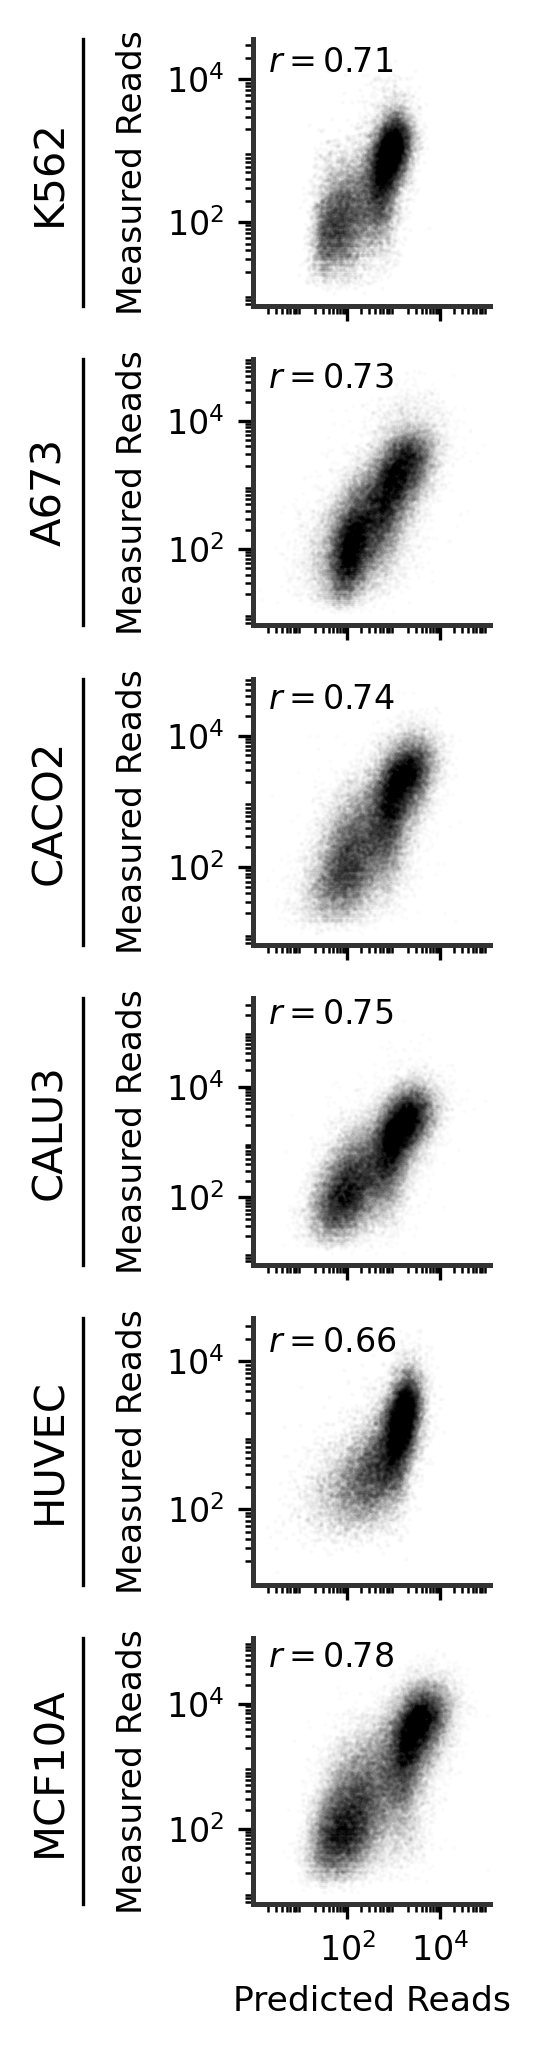

In [181]:
def add_extra_ylabel(axis, label, offset = -1.05, fontsize=15, line=True):
    # this lets you have an extra bit of text to the left of the plot's ylabel
    # (line=True means draw vertical line between original ylabel and extra one)
    
    ax2 = axis.twinx()
    ax2.spines[["top","right","bottom"]].set_visible(False)
    if line:
        ax2.spines["left"].set_position(("axes", offset))
    else:
        ax2.spines["left"].set_visible(False)
    ax2.yaxis.set_label_position('left')
    ax2.yaxis.set_ticks_position('none')
    ax2.set_yticklabels([])
    ax2.set_ylabel(label, fontsize = fontsize, labelpad=3)


def plot_pred_vs_true_counts_all_cells(all_pred_logcounts,
                                       all_true_counts, cell_types,
                                       save_path=None):
    
    fig, axes = plt.subplots(len(cell_types),
                             figsize=(1.2 * 0.85, 9.5 * 0.85), dpi=300, sharex=True)

    max_y_ever = 0
    for ax, cell_type in zip(axes, cell_types):
        pred_logcounts = all_pred_logcounts[cell_type]
        true_counts = all_true_counts[cell_type]
    
        # calculate max across all cell types to set y-axis later
        max_y_ever = max(max_y_ever, np.max(true_counts))
        
        # if the model preds/data are stranded, merge the two strands
        if len(pred_logcounts.shape) > 1:
            pred_logcounts = np.sum(pred_logcounts, axis=-1)
        if len(true_counts.shape) > 1:
            true_counts = np.sum(true_counts, axis=-1)
        assert pred_logcounts.shape == true_counts.shape

        # it causes pain if the K562 plot looks different from Fig1,
        # but all the other plots look better with changed alpha
        
        if cell_type in ["K562", "HUVEC"]:
            ax.scatter(np.exp(pred_logcounts), true_counts,
                        alpha = 0.025, s = 1, color="k", linewidths=0)
        else:
            ax.scatter(np.exp(pred_logcounts), true_counts,
                        alpha = 0.015, s = 1, color="k", linewidths=0)

        ax.semilogy()
        ax.semilogx()

        add_extra_ylabel(ax, cell_type, offset=-0.72, fontsize=10)
        
        if cell_type == cell_types[-1]:
            ax.set_xlabel("Predicted Reads", fontsize=8.3)
        
        ax.set_ylabel("Measured Reads", fontsize=8.3)
            

        # annotate with pearson corr. text in upper left
        
        pearson_r = np.corrcoef(pred_logcounts,
                                np.log1p(true_counts))[0,1]
        
        ax.text(2, ax.get_ylim()[1]*0.35,
                r'$r = %0.2f$' % pearson_r, fontsize=8) 
        
        # aesthetics
        
        ax.set_xticks([10**2, 10**4])
        ax.tick_params(labelsize=8)
        
        ax.spines[["left","bottom"]].set_linewidth(1.2)
        ax.spines[["left","bottom"]].set_color("#333333")
        ax.spines[["top","right"]].set_visible(False)
        # make the axes have the little log-scale ticks
        ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
        ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
        
    for ax in axes:
        ax.set_xlim(0.95, 120000) ## I checked this was less than max of x-axis vals
    
    # set y-axis to be consistent across all plots, include the max of any plot
    plt.ylim(3, max_y_ever * 1.1)
    fig.subplots_adjust(wspace=0.275)
        
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
        
    plt.show()
    

plot_pred_vs_true_counts_all_cells(pred_logcounts, true_counts, cell_types,
                                   save_path = figures_dir + "celltypes_test_counts_tall.png")

### Profile Task

In [10]:
# To stratify performance across folds, we need to label
# each test example with which fold it was in the test set for.

# Fold assignment (below) needs to match what was in
# 1_process_data/_split_peaks_train_val_test.py

FOLDS = [["chr1", "chr4"],
         ["chr2", "chr13", "chr16"],
         ["chr5", "chr6", "chr20", "chr21"],
         ["chr7", "chr8", "chr9"],
         ["chr10", "chr11", "chr12"],
         ["chr3", "chr14", "chr15", "chr17"],
         ["chr18", "chr19", "chr22", "chrX", "chrY"]]

def get_fold_label(chrom):
    # returns *0-indexed* fold num that this chromosome was in the test set for
    for fold_i, fold_chroms in enumerate(FOLDS):
            if chrom in fold_chroms:
                return fold_i
    return -1

def make_fold_labels(coords):
    # Make list of len [num_peaks] / length of all_peak_path file,
    # where entry i is the fold that example i was in the test set for.
    
    # coord[0] is the chromosome (first column from bed file)
    fold_labels = [get_fold_label(coord[0]) for coord in coords]
    
    # check we assigned a fold for every single example/peak
    assert all([label > -1 for label in fold_labels]), fold_labels
    return fold_labels

def make_fold_labels_all_cells(cell_types, model_type=model_type,
                               data_type=data_type, in_window=in_window):
    fold_labels = dict()
    for cell_type in cell_types:
        merged_config = MergedFilesConfig(cell_type, model_type, data_type)
        coords = load_coords(merged_config.all_peak_path, in_window)
        fold_labels[cell_type] = make_fold_labels(coords)
    return fold_labels


fold_labels = make_fold_labels_all_cells(cell_types)

In [157]:
def get_avg_train_obs_profile_over_folds(true_profs, fold_labels):
    # For each fold, calculate the average PRO-cap profile across all examples
    # in the training or validation (not-test) sets (to use as a baseline).
    # Then, build a list the same length as fold_labels, where the ith entry
    # is the average train-val profile for the fold that example i belonged to.
    
    folds = sorted(list(set(fold_labels)))
    
    avg_profiles = []
    for fold in folds:
        # convert numeric fold labels to booleans
        in_train_val_fold = np.array([fold_label != fold for fold_label in fold_labels])
        
        # subset to profiles that were in the train-val sets for this fold
        true_profs_fold = true_profs[in_train_val_fold]
        
        # calculate mean per-base, keeping strands separate
        avg_profiles.append(np.mean(true_profs_fold, axis=0))
        
    avg_profiles_tiled = []
    for fold_label in fold_labels:
        avg_profiles_tiled.append(avg_profiles[fold_label])
    return np.array(avg_profiles_tiled)

def get_avg_profiles_over_folds_all_cells(cell_types, true_profs, fold_labels):
    avg_profs = dict()
    for cell_type in cell_types:
        avg_profs[cell_type] = get_avg_train_obs_profile_over_folds(true_profs[cell_type],
                                                                    fold_labels[cell_type])
    return avg_profs
    
avg_profiles_over_folds = get_avg_profiles_over_folds_all_cells(cell_types, true_profs, fold_labels)

In [158]:
def calc_profile_jsds_and_corrs(profs1, profs2):
    assert profs1.shape == profs2.shape, (profs1.shape, profs2.shape)
    
    # assuming none of these profiles are in log-space

    jsds = []
    pearson_rs = []
    for prof1, prof2 in zip(profs1, profs2):
        # if multiple strands, flatten data across them into 1D array
        prof1 = prof1.flatten()
        prof2 = prof2.flatten()
        
        jsd = jensenshannon(prof1, prof2, base=2)
        jsds.append(jsd)
        
        pearson_r = np.corrcoef(prof1, prof2)[0,1]
        pearson_rs.append(pearson_r)
        
    return np.array(jsds), np.array(pearson_rs)

KeyboardInterrupt: 

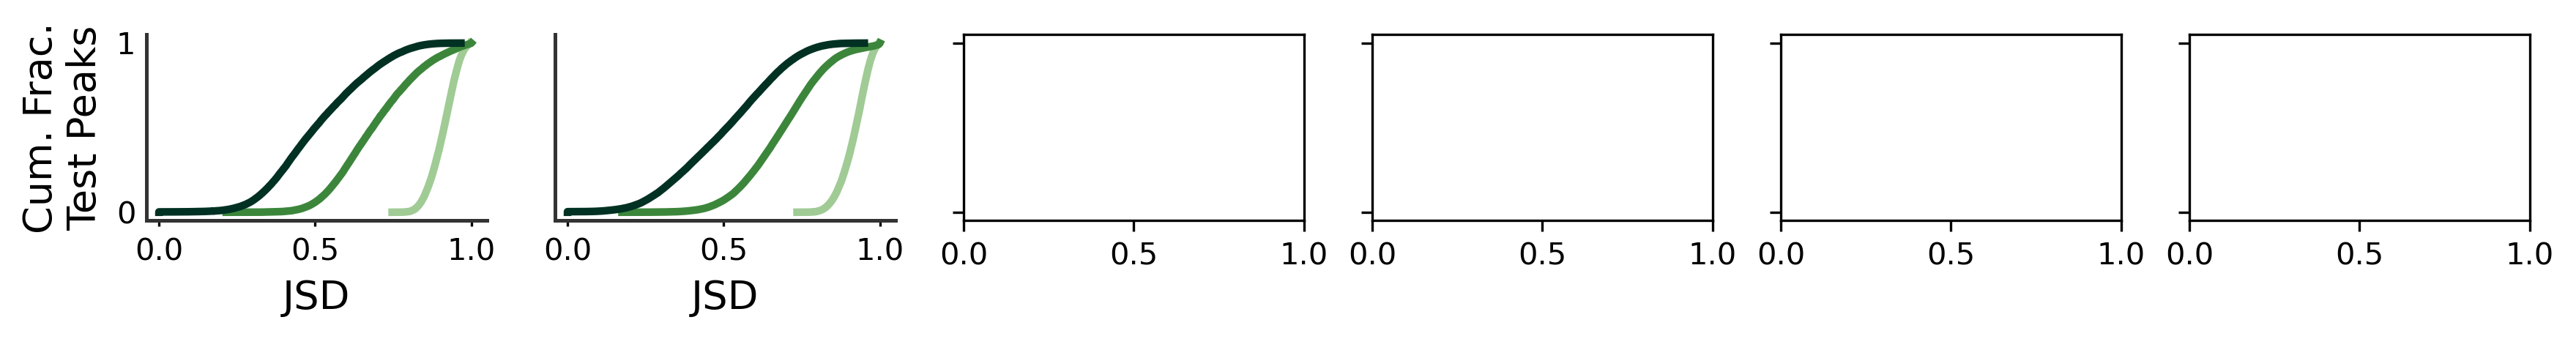

In [159]:
def plot_prof_performance_cdf_all_cells(cell_types, true_profs, pred_profs,
                                        pseudorep1_profs, pseudorep2_profs,
                                        avg_profiles_over_folds, save_path=None):

    fig, axes = plt.subplots(1, len(cell_types), figsize=(14,1.1), sharey = True, dpi=300)
    
    for ax, cell_type in zip(axes, cell_types):
        # compare model predictions vs. observed data on the test sets
        jsds_pred_vs_obs, _ = calc_profile_jsds_and_corrs(true_profs[cell_type],
                                                          pred_profs[cell_type])

        # baseline 1: observed data pseudoreplicate 1 vs. observed data pseudoreplicate 2 on test sets
        jsds_pseudoreps, _ = calc_profile_jsds_and_corrs(pseudorep1_profs[cell_type],
                                                         pseudorep2_profs[cell_type])

        # baseline 2: average data profile in the training + validation set vs. observed data on test sets
        jsds_avg_baseline, _ = calc_profile_jsds_and_corrs(true_profs[cell_type],
                                                           avg_profiles_over_folds[cell_type])
          
        pred_vs_obs = np.sort(jsds_pred_vs_obs)
        rep_baseline = np.sort(jsds_pseudoreps)
        rand_baseline = np.sort(jsds_avg_baseline)
        cdf = np.array(range(len(pred_vs_obs)))/float(len(pred_vs_obs))

        ax.plot(rand_baseline, cdf, color="#A0CB95", alpha=1, label="Avg. Profile vs. Measured", linewidth=2.5)
        ax.plot(pred_vs_obs, cdf, color="#3C863C", alpha=1, label="Predicted vs. Measured", linewidth=2.5)
        ax.plot(rep_baseline, cdf, color="#003123", alpha=1, label="Pseudoreplicates", linewidth=2.5)

        # aesthetics
            
        ax.set_xlabel("JSD", fontsize = 13)
            
        if cell_type == cell_types[0]:
            ax.set_ylabel("Cum. Frac.\nTest Peaks", fontsize = 13)
        
        ax.set_xlim(-0.04, ax.get_xlim()[1])
        ax.set_yticks([0, 1], fontsize=8)
        
        ax.spines[["left","bottom"]].set_linewidth(1.2)
        ax.spines[["left","bottom"]].set_color("#333333")
        ax.spines[["top","right"]].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.tick_params("y", length=0)
        ax.set_xticks([0, 0.5, 1])
        ax.tick_params("x", length=2)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles[::-1], labels[::-1], frameon=False, fontsize=11, ncol=3,
               bbox_to_anchor=(0.5, -0.3), loc='upper center')
        
    fig.subplots_adjust(hspace=0.25)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    plt.show()

plot_prof_performance_cdf_all_cells(cell_types, true_profs, pred_profs,
                                    pseudorep1_profs, pseudorep2_profs,
                                    avg_profiles_over_folds,
                                    save_path = figures_dir + "celltypes_test_prof_wide.png")

In [163]:
def calc_all_jsds(cell_types, true_profs, pred_profs, pseudorep1_profs, pseudorep2_profs,
                  avg_profiles_over_folds):
    jsds_pred_vs_obs = dict()
    jsds_pseudoreps = dict()
    jsds_avg_baseline = dict()
    
    for cell_type in cell_types:
        # compare model predictions vs. observed data on the test sets
        jsds_pred_vs_obs[cell_type], _ = calc_profile_jsds_and_corrs(true_profs[cell_type],
                                                          pred_profs[cell_type])

        # baseline 1: observed data pseudoreplicate 1 vs. observed data pseudoreplicate 2 on test sets
        jsds_pseudoreps[cell_type], _ = calc_profile_jsds_and_corrs(pseudorep1_profs[cell_type],
                                                         pseudorep2_profs[cell_type])

        # baseline 2: average data profile in the training + validation set vs. observed data on test sets
        jsds_avg_baseline[cell_type], _ = calc_profile_jsds_and_corrs(true_profs[cell_type],
                                                           avg_profiles_over_folds[cell_type])
        
    return jsds_pred_vs_obs, jsds_pseudoreps, jsds_avg_baseline


jsds_pred_vs_obs, jsds_pseudoreps, jsds_avg_baseline = calc_all_jsds(cell_types,
                                                                     true_profs, pred_profs,
                                                                     pseudorep1_profs, pseudorep2_profs,
                                                                     avg_profiles_over_folds)

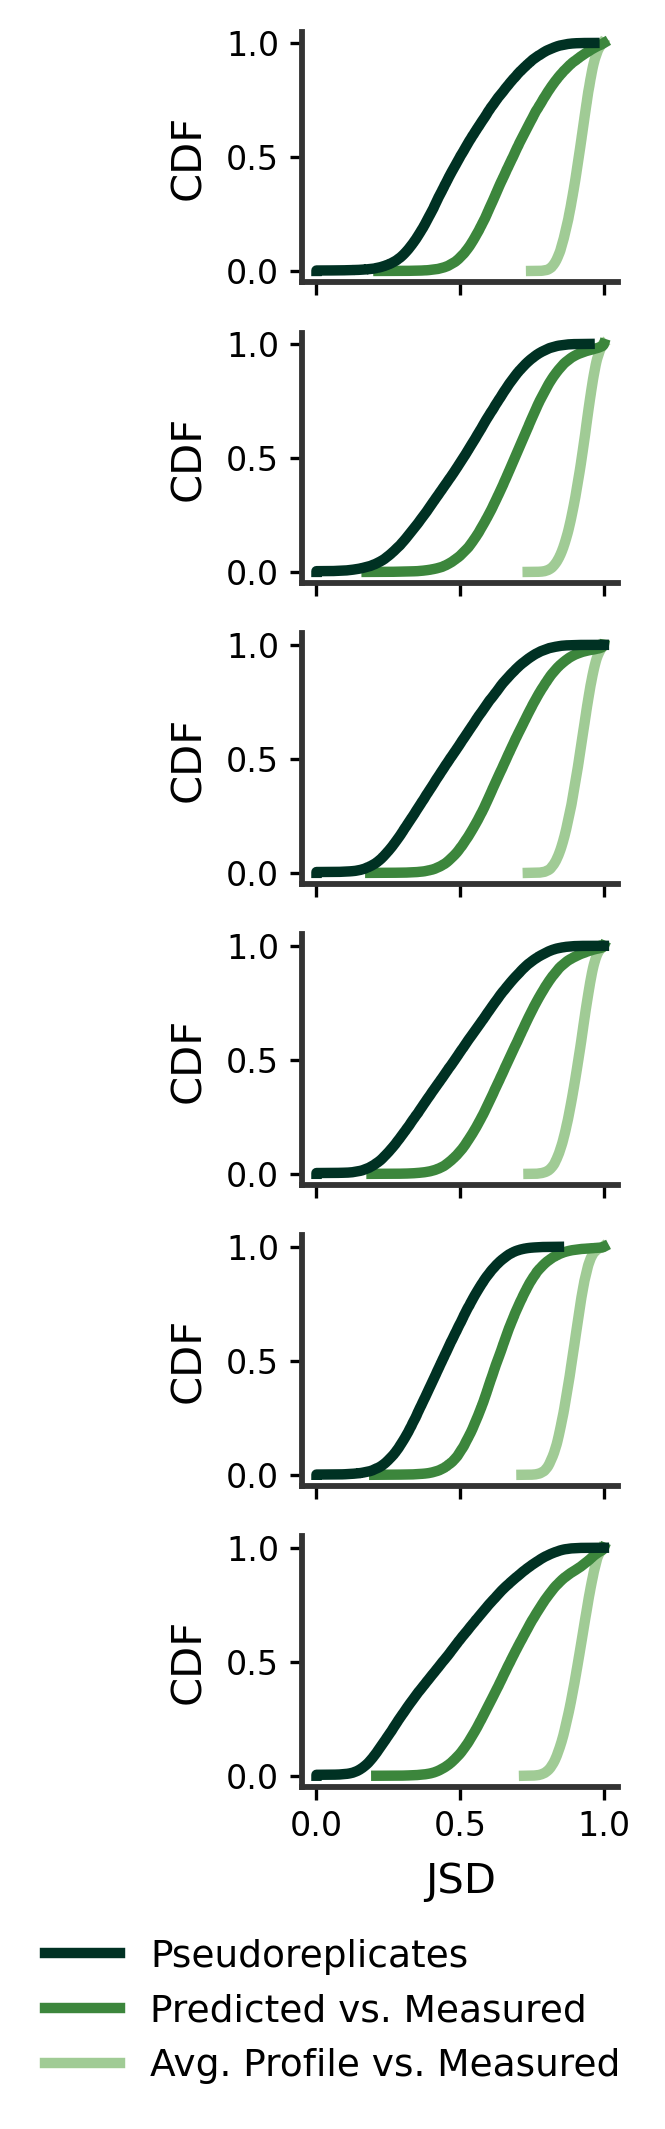

In [185]:
def plot_prof_performance_cdf_all_cells(cell_types, jsds_pred_vs_obs,
                                        jsds_pseudoreps, jsds_avg_baseline,
                                        save_path=None):
    
    fig, axes = plt.subplots(len(cell_types),
                             figsize=(1.7 * 0.8, 9.5 * 0.8), dpi=300, sharex=True)

    max_y_ever = 0
    for ax, cell_type in zip(axes, cell_types):
        pred_vs_obs = np.sort(jsds_pred_vs_obs[cell_type])
        rep_baseline = np.sort(jsds_pseudoreps[cell_type])
        rand_baseline = np.sort(jsds_avg_baseline[cell_type])
        cdf = np.array(range(len(pred_vs_obs)))/float(len(pred_vs_obs))

        ax.plot(rand_baseline, cdf, color="#A0CB95", alpha=1, label="Avg. Profile vs. Measured", linewidth=2.5)
        ax.plot(pred_vs_obs, cdf, color="#3C863C", alpha=1, label="Predicted vs. Measured", linewidth=2.5)
        ax.plot(rep_baseline, cdf, color="#003123", alpha=1, label="Pseudoreplicates", linewidth=2.5)
        
        if cell_type == cell_types[-1]:
            ax.set_xlabel("JSD", fontsize = 10, labelpad=4.5)
            
        ax.set_ylabel("CDF", fontsize = 10)
        
        # aesthetics
        
        ax.tick_params(labelsize=8, length=3, pad=2.5)
        
        ax.spines[["left","bottom"]].set_linewidth(1.4)
        ax.spines[["left","bottom"]].set_color("#333333")
        ax.spines[["top","right"]].set_visible(False)

    fig.subplots_adjust(wspace=0.275)
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles[::-1], labels[::-1], frameon=False, fontsize=9, ncol=1,
               bbox_to_anchor=(0.2, -0.035), loc='lower center')
        
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
        
    plt.show()


plot_prof_performance_cdf_all_cells(cell_types, jsds_pred_vs_obs,
                                    jsds_pseudoreps, jsds_avg_baseline,
                                    save_path = figures_dir + "celltypes_test_prof_tall.png")

# Union Peak Set Analysis

In [18]:
def load_observed_union_peak_data(cell_types, union_peaks_path,
                         genome_path, chrom_sizes,
                         model_type=model_type, data_type=data_type):

    true_counts = dict()
    true_profiles = dict()
    for cell_type in cell_types:
        print(cell_type)
        config = MergedFilesConfig(cell_type, model_type, data_type)
        
        true_profs = extract_observed_profiles(config.plus_bw_path,
                                               config.minus_bw_path,
                                               union_peaks_path,
                                               out_window=out_window)
        
        true_profiles[cell_type] = true_profs
        true_counts[cell_type] = true_profs.sum(axis=(-1,-2)).squeeze()
        
    return true_counts, true_profiles


union_true_counts, union_true_profiles = load_observed_union_peak_data(cell_types,
                                                                union_peaks_all_path,
                                                                genome_path, chrom_sizes)

K562
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697
A673
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697
CACO2
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697
CALU3
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697
HUVEC
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697
MCF10A
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


In [14]:
# load in predictions made by predict_union_peaks_all_cells.py (you need to run that first)

union_preds_save_path = proj_dir + "src/figure_notebooks/fig_cell_types_union_preds/"

union_pred_logcounts = dict()
union_pred_profiles = dict()

for cell_type in cell_types:
    union_pred_logcounts[cell_type] = np.load(union_preds_save_path + cell_type + "_pred_logcounts.npy").squeeze()
    union_pred_profiles[cell_type] = np.load(union_preds_save_path + cell_type + "_pred_profiles.npy")

In [19]:
union_pred_logcounts["K562"].shape, union_true_counts["K562"].shape

((103697,), (103697,))

## Fig. 8B: Cell-Pair Predictions + Data Scatterplots

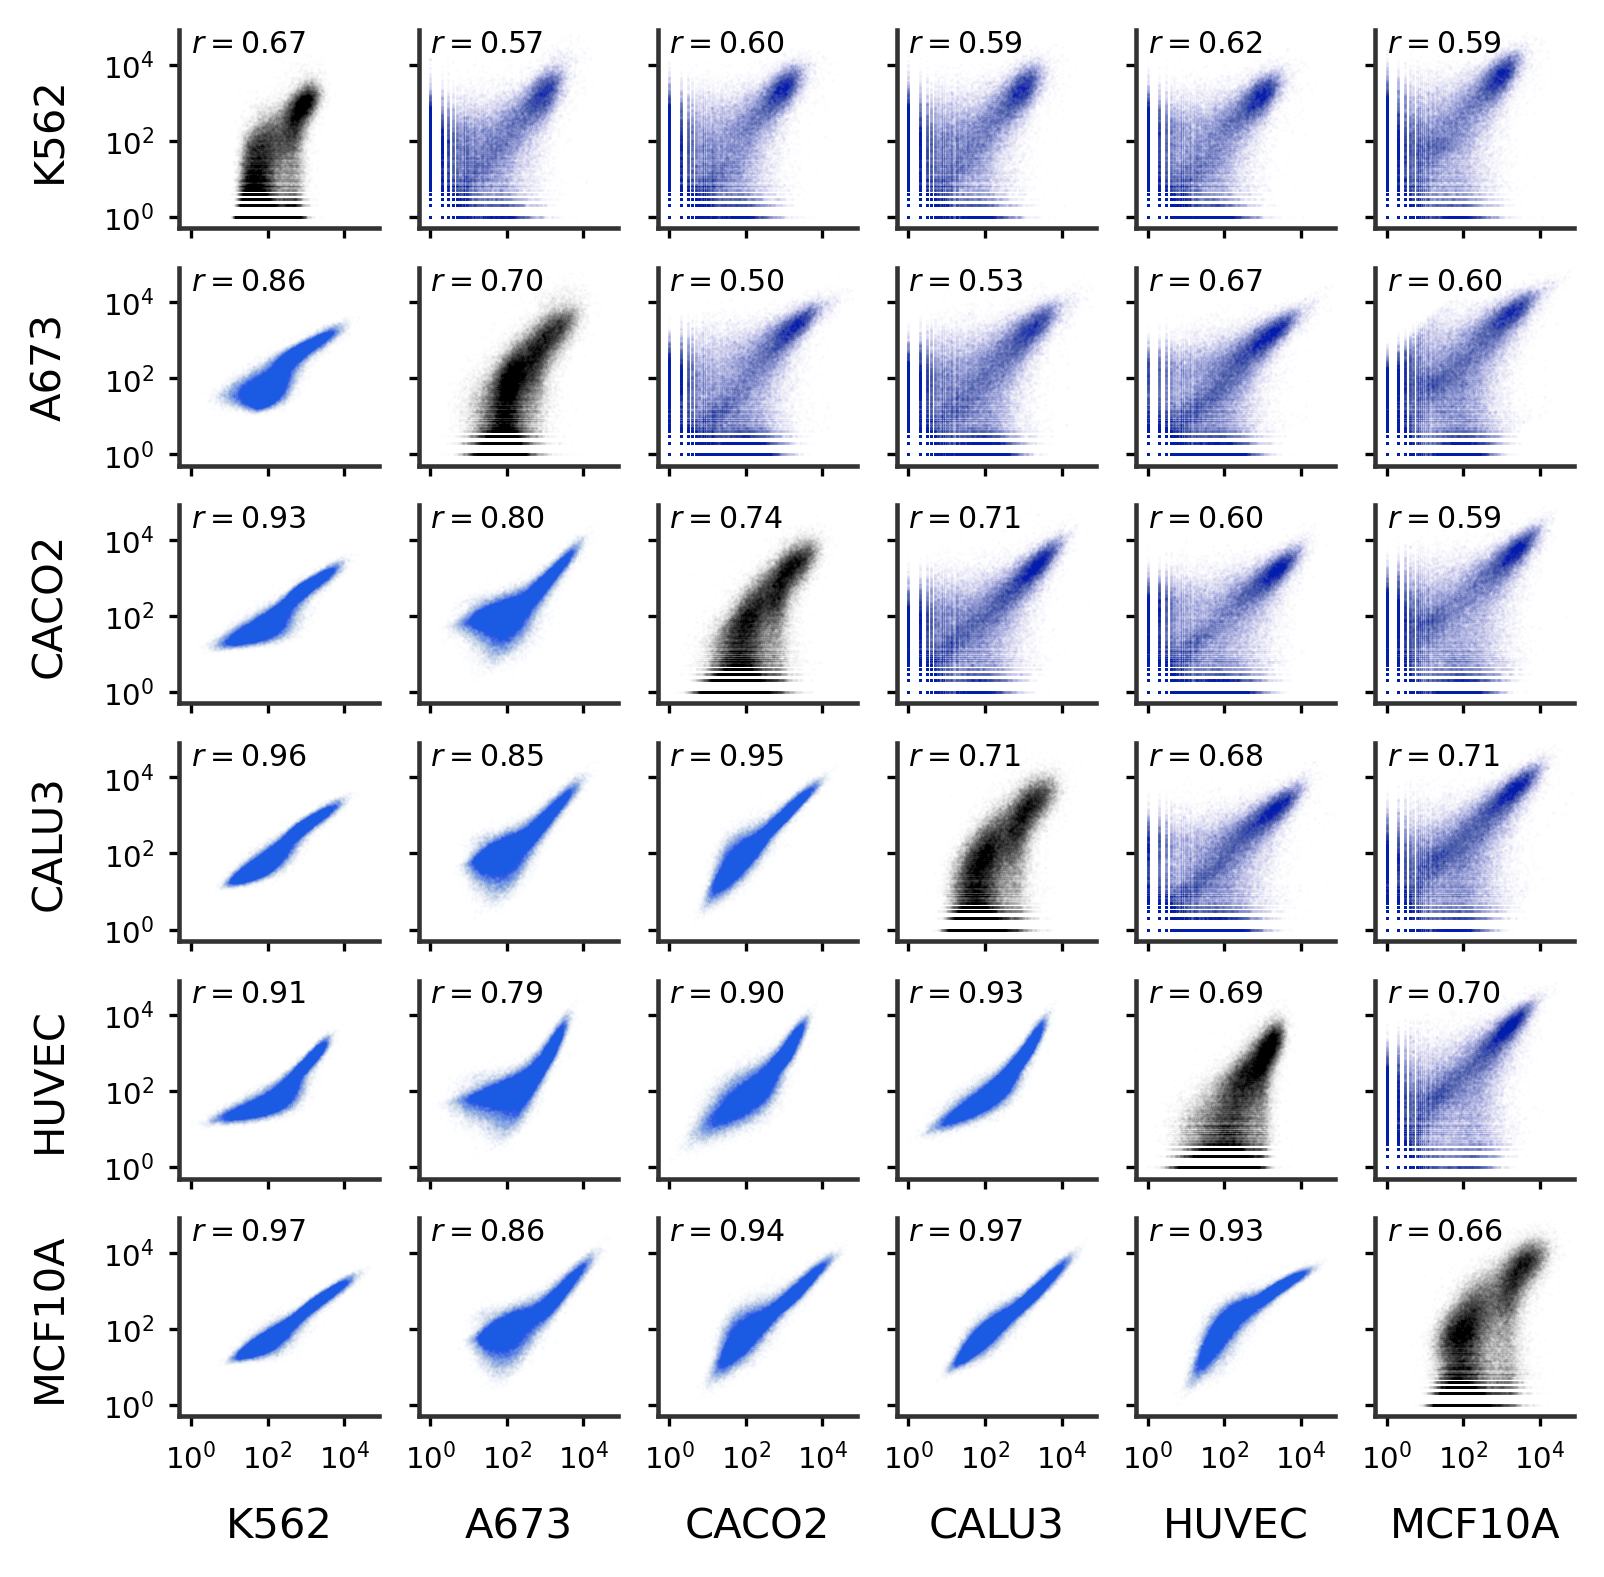

In [193]:
def plot_union_counts_scatter_matrix(all_pred_counts, all_true_counts, cell_types, save_path=None):
    
    fig, axes = plt.subplots(len(cell_types), len(cell_types), dpi=300,
                             figsize=(6, 6), sharex=True, sharey=True)
    
    max_xlim_so_far = 0
    max_ylim_so_far = 0
    
    for i, (ax_row, cell_1) in enumerate(zip(axes, cell_types)):
        pred_counts1 = all_pred_counts[cell_1]
        true_counts1 = all_true_counts[cell_1]
        for j, (ax, cell_2) in enumerate(zip(ax_row, cell_types)):
            pred_counts2 = all_pred_counts[cell_2]
            true_counts2 = all_true_counts[cell_2]

            pred_counts1 = pred_counts1.squeeze().flatten()
            pred_counts2 = pred_counts2.squeeze().flatten()
            
            true_counts1 = true_counts1.squeeze().flatten()
            true_counts2 = true_counts2.squeeze().flatten()

            assert pred_counts1.shape == pred_counts2.shape, (pred_counts1.shape, pred_counts2.shape)
            assert true_counts1.shape == true_counts2.shape, (true_counts1.shape, true_counts2.shape)

            if i > j:
                pearson_r = np.corrcoef(pred_counts1, pred_counts2)[0,1]

                ax.scatter(np.exp(pred_counts1),
                           np.exp(pred_counts2),
                            alpha = 0.01, s = 0.5, color="#1B5AE3", linewidths=0)
            elif i == j:
                pearson_r = np.corrcoef(pred_counts1, np.log1p(true_counts2))[0,1]
                
                ax.scatter(np.exp(pred_counts1),
                           true_counts2 + 1,
                            alpha = 0.01, s = 0.5, color="k", linewidths=0)
            else:
                pearson_r = np.corrcoef(np.log1p(true_counts1), np.log1p(true_counts2))[0,1]

                ax.scatter(true_counts1 + 1,
                           true_counts2 + 1,
                           alpha = 0.01, s = 0.5, color="#001DAC", linewidths=0)

            ax.semilogy()
            ax.semilogx()

            if cell_1 == cell_types[-1]:
                ax.set_xlabel(cell_2, fontsize=10, labelpad=8)

            if cell_2 == cell_types[0]:
                ax.set_ylabel(cell_1, fontsize=10, labelpad=8)
                
            if pearson_r is not None:
                ax.text(1, 21000,
                         r'$r = %0.2f$' % pearson_r,
                         fontsize=7.2)

            ax.spines[["left", "bottom"]].set_linewidth(1.1)
            ax.spines[["left", "bottom"]].set_color("#333333")
            ax.spines[["top", "right"]].set_visible(False)

            ax.tick_params("both", length=2.5, labelsize=7)
            ax.set_xticks([10**0, 10**2, 10**4])
            ax.set_yticks([10**0, 10**2, 10**4])
            
            ax.set_xlim(0.5, 10**4 * 8)
            ax.set_ylim(0.5, 10**4 * 8)

            
        
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    plt.show()
    

plot_union_counts_scatter_matrix(union_pred_logcounts, union_true_counts, cell_types,
                                 save_path = figures_dir + "celltypes_scatter_matrix.png")

### Making The Legend

In [195]:
def get_corner_highlight_coords(n_rows):
    # assuming n_rows = n_cols
    # want (5.5, 0.5), (4.5, 0.5), (4.5, 1.5), ..., (0.5, 5.5)
    
    curr_x = 0.5
    curr_y = -0.5
    
    coords_list = [(curr_x, curr_y)]
    while curr_x < n_rows - 0.5:
        curr_y += 1
        coords_list.append((curr_x, curr_y))
        curr_x += 1
        coords_list.append((curr_x, curr_y))
        
    coords_list.append((n_rows - 0.5, -0.5))
    coords_list.append(coords_list[0])  # back to start
    
    return np.array(coords_list)


def get_diagonal_highlight_coords(n_rows):
    # assuming n_rows = n_cols
    # want (5.5, 0.5), (4.5, 0.5), (4.5, 1.5), ..., (0.5, 5.5)
    
    curr_x = -0.5
    curr_y = -0.5
    
    coords_list = [(curr_x, curr_y)]
    while curr_x < n_rows - 0.5:
        curr_y += 1
        coords_list.append((curr_x, curr_y))
        curr_x += 1
        coords_list.append((curr_x, curr_y))
    
    while curr_x > -0.5:
        curr_y -= 1
        coords_list.append((curr_x, curr_y))
        curr_x -= 1
        coords_list.append((curr_x, curr_y))
    
    return np.array(coords_list)

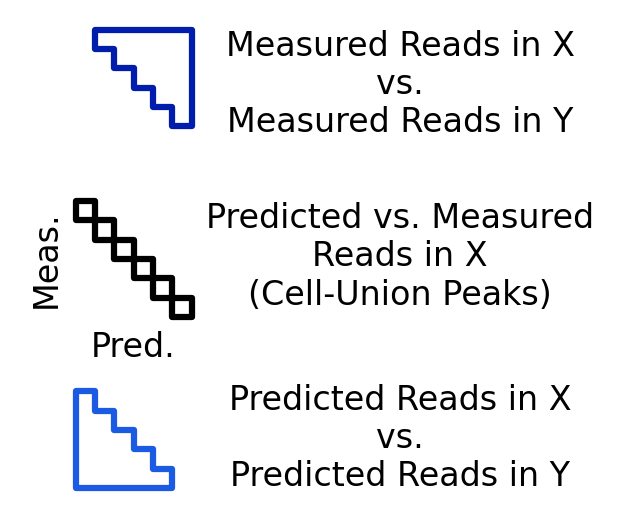

In [198]:
def drew_legend_for_scatter_matrix(cell_types, save_path=None):
    n_cell_types = len(cell_types)
    
    regions = ["topright", "diagonal", "bottomleft"]
    labels = ["Measured Reads in X\nvs.\nMeasured Reads in Y",
              "Predicted vs. Measured\nReads in X\n(Cell-Union Peaks)",
              "Predicted Reads in X\nvs.\nPredicted Reads in Y"]
    colors = ["#001DAC", "k", "#1B5AE3"]
    assert len(regions) == len(labels) and len(regions) == len(colors)
    
    blank_map = np.full((n_cell_types, n_cell_types), np.nan)
    
    fig, axes = plt.subplots(len(regions), figsize=(0.5,0.7 * 3), dpi=300)
    
    for (ax, region, label, color) in zip(axes, regions, labels, colors):
        ax.imshow(blank_map)

        if region == "topright":
            highlight_coords = get_corner_highlight_coords(n_cell_types)
            y_adj = 0
        elif region == "bottomleft":
            highlight_coords = get_corner_highlight_coords(n_cell_types)[:, ::-1]
            y_adj = -0.1
        elif region == "diagonal":
            highlight_coords = get_diagonal_highlight_coords(n_cell_types)
            y_adj = -0.1
            ax.set_xlabel("Pred.", fontsize=8, labelpad=-3.5)
            add_extra_ylabel(ax, "Meas.", fontsize=8, line=False)
        else:
            assert region in ["topright", "diagonal", "bottomleft"], region
            
        ax.add_collection(PatchCollection([Polygon(highlight_coords)],
                                          color=color, facecolor="none",
                                          linewidth=1.5, clip_on=False))
        
        ax.set_ylabel(label, rotation=0, fontsize=8, y=1 + y_adj, labelpad=50)
        ax.yaxis.set_label_position("right")
    
        ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.align_ylabels()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
    
    plt.show()
    
    
drew_legend_for_scatter_matrix(cell_types, save_path = figures_dir + "celltypes_scatter_matrix_legend.png")

## Chromatin Info Across Union Peaks Analysis

In [11]:
# we have more datasets available in K562 than the other cell types

# in K562:
K562_chromatin_data_names = ["H3K4me3", "H3K4me1", "H3K4me2", "H3K27ac", "H3K27me3",
                        "H3K9ac", "H3K9me3", "H3K9me1", "H3K36me3", "H3K79me2", "ATAC", "DNase"]
# in the other cell types:
chromatin_data_names = ["H3K4me3", "H3K4me1", "H3K27me3", "H3K9me3", "H3K27ac", "H3K36me3", "DNase"]

# these are the cell types we have (at least some of) these datasets in (thanks Roadmap)
cell_types_with_data = ["K562", "A673", "CACO2", "HUVEC"]


# these files are downloaded by the script 0_download_files/0.2_download_histone_marks.sh

def get_chrom_data_path(cell_type, chrom_data_name):
    chromatin_data_dir = proj_dir + "annotations/" + cell_type + "/"
    return chromatin_data_dir + chrom_data_name + ".bigWig"

In [20]:
def load_union_chromatin_data(cell_types):
    chromatin_data = defaultdict(lambda : dict())
    
    for cell_type in cell_types:
        if cell_type == "K562":
            for data_name in K562_chromatin_data_names:
                bw_filepath = get_chrom_data_path(cell_type, data_name)
                # pass in bw twice because code expects stranded data; but then toss one "strand"
                chromatin_data[cell_type][data_name] = extract_observed_profiles(bw_filepath, bw_filepath,
                                                                                 union_peaks_path,
                                                                                 out_window=1000,
                                                                                 verbose=True)[:, 0, :]
            
        else:
            for data_name in chromatin_data_names:
                bw_filepath = get_chrom_data_path(cell_type, data_name)
                # pass in bw twice because code expects stranded data; but then toss one "strand"
                try:
                    chromatin_data[cell_type][data_name] = extract_observed_profiles(bw_filepath, bw_filepath,
                                                                                     union_peaks_path,
                                                                                     out_window=1000,
                                                                                     verbose=True)[:, 0, :]
                except:
                    empty_array = np.empty((union_true_counts[cell_type].shape[0],1000))
                    empty_array[:] = np.nan
                    print("Empty array for " + cell_type + " " + data_name)
                    print(empty_array.shape)
                    chromatin_data[cell_type][data_name] = empty_array
                
    return chromatin_data

union_chromatin_data = load_union_chromatin_data(cell_types_with_data)

Loading Profiles: 103697it [00:25, 4037.08it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:22, 4629.12it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:23, 4452.73it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:24, 4249.85it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:21, 4857.94it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:23, 4464.12it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:22, 4694.45it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:22, 4708.48it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:23, 4458.20it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:23, 4403.61it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:28, 3680.48it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:21, 4905.73it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:24, 4232.25it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:23, 4431.18it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:23, 4466.36it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:22, 4657.42it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:23, 4364.01it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:22, 4614.67it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:20, 5095.52it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:23, 4424.06it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:26, 3931.82it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 103697it [00:22, 4678.57it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/union_peaks.bed.gz
Profile length: 1000
Num. Examples: 103697


Loading Profiles: 48817it [00:11, 4165.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
def load_K562_chromatin_data(model_type=model_type, data_type=data_type):
    # since we will make a plot that requires data from just the K562 peak set
    
    K562_chromatin_data = dict()
    
    K562_config = MergedFilesConfig("K562", model_type, data_type)
    
    for data_name in K562_chromatin_data_names:
        bw_filepath = get_chrom_data_path("K562", data_name)
        # pass in bw twice because code expects stranded data; but then toss one "strand"
        K562_chromatin_data[data_name] = extract_observed_profiles(bw_filepath, bw_filepath,
                                                                   K562_config.all_peak_path,
                                                                   out_window=1000,
                                                                   verbose=True)[:, 0, :]
    return {"K562" : K562_chromatin_data}
                
K562_chromatin_data = load_K562_chromatin_data()

Loading Profiles: 30534it [00:10, 2908.42it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


Loading Profiles: 30534it [00:07, 3914.94it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


Loading Profiles: 30534it [00:08, 3552.88it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


Loading Profiles: 30534it [00:09, 3198.60it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


Loading Profiles: 30534it [00:06, 4495.57it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


Loading Profiles: 30534it [00:08, 3584.85it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


Loading Profiles: 30534it [00:08, 3688.86it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


Loading Profiles: 30534it [00:07, 4169.84it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


Loading Profiles: 30534it [00:07, 4018.35it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534



Loading Profiles: 30534it [00:08, 3654.14it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


Loading Profiles: 30534it [00:15, 1924.76it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


Loading Profiles: 30534it [00:07, 4100.88it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


In [22]:
def load_K562_obs_data_and_preds(model_type=model_type, data_type=data_type):
    # since we will make a plot that requires data from just the K562 peak set
    
    K562_config = MergedFilesConfig("K562", model_type, data_type)
    
    # Load observed PRO-cap signal
    true_profs = extract_observed_profiles(K562_config.plus_bw_path,
                                           K562_config.minus_bw_path,
                                           K562_config.all_peak_path,
                                           out_window=out_window,
                                           verbose=True)
    true_counts = true_profs.sum(axis=(-1,-2)).squeeze()

    # Load model predictions
    pred_logcounts = np.load(K562_config.pred_logcounts_all_path).squeeze()
    return pred_logcounts, true_counts
    
                
K562_peaks_pred_logcounts, K562_peaks_true_counts = load_K562_obs_data_and_preds()

Loading Profiles: 30534it [00:06, 4816.77it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


In [23]:
# how to summarize a track vector across a peak window into one number?
# for now, we will take the mean of the log of the raw data across the peak width

def process_union_chromatin_data(union_chromatin_data, cell_types_with_data=cell_types_with_data):
    chromatin_data_mean = defaultdict(lambda : dict())
    
    for cell_type in cell_types_with_data:
        for data_name in K562_chromatin_data_names:
            if data_name in union_chromatin_data[cell_type].keys():
                data_raw = union_chromatin_data[cell_type][data_name]
                chromatin_data_mean[cell_type][data_name] = np.log1p(data_raw).mean(axis=-1)
                
    return chromatin_data_mean

union_chromatin_data_mean = process_union_chromatin_data(union_chromatin_data)

In [24]:
def process_K562_chromatin_data(K562_chromatin_data):
    chromatin_data_mean = defaultdict(lambda : dict())
    for data_name, data in K562_chromatin_data["K562"].items():
        chromatin_data_mean["K562"][data_name] = np.log1p(data).mean(axis=-1)
    return chromatin_data_mean

K562_chromatin_data_mean = process_K562_chromatin_data(K562_chromatin_data)

In [41]:
def make_union_fold_labels(union_peaks_path, in_window=in_window):
    coords = load_coords(union_peaks_path, in_window)
    return make_fold_labels(coords)

fold_labels_union_peaks = make_union_fold_labels(union_peaks_path)

## Coloring Pred. vs. Obs. Data by Chromatin Info: Fig. 8C

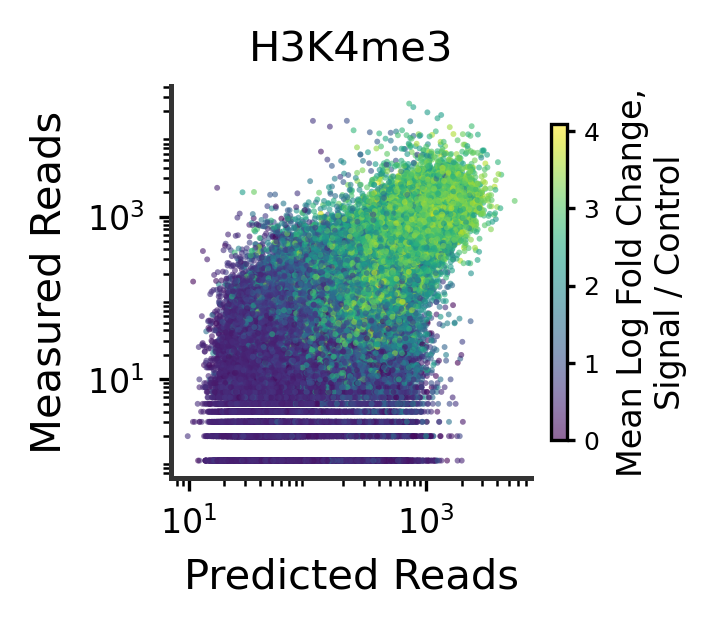

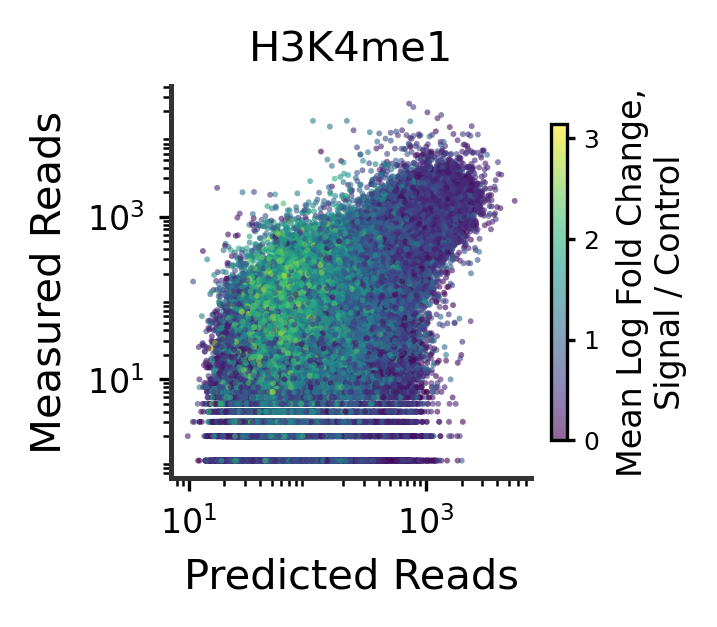

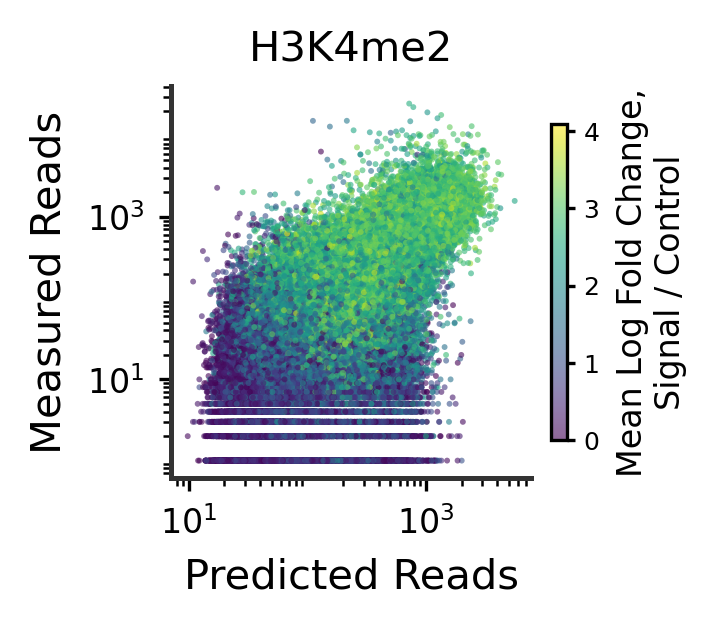

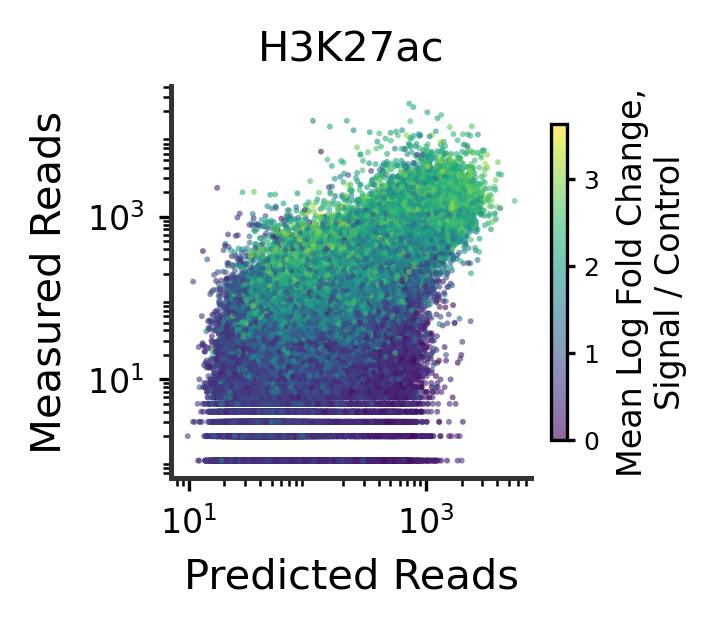

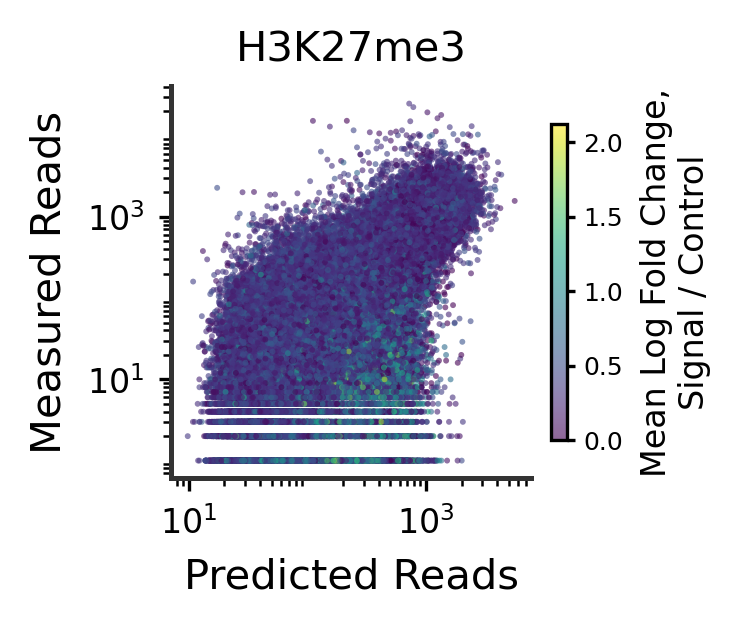

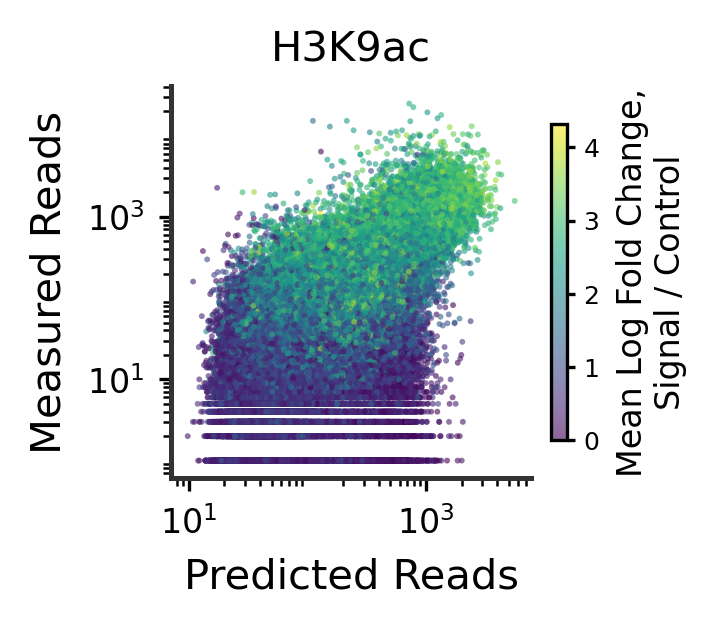

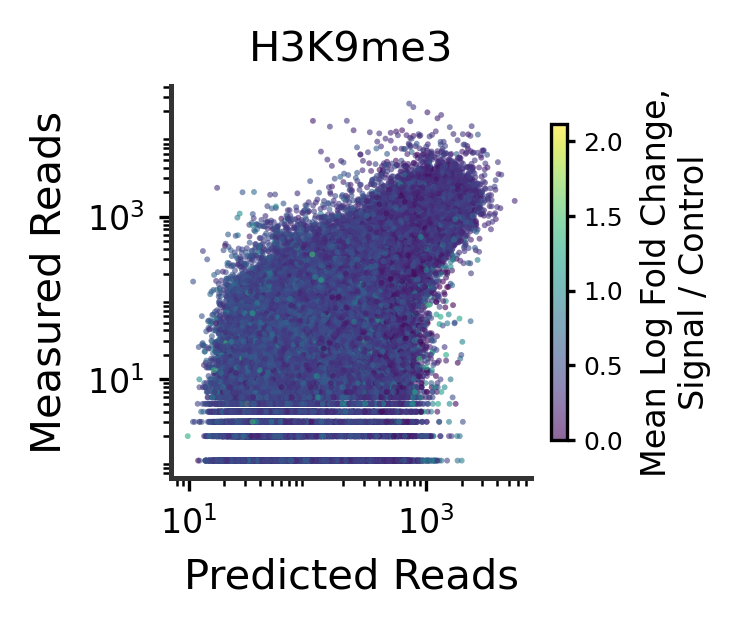

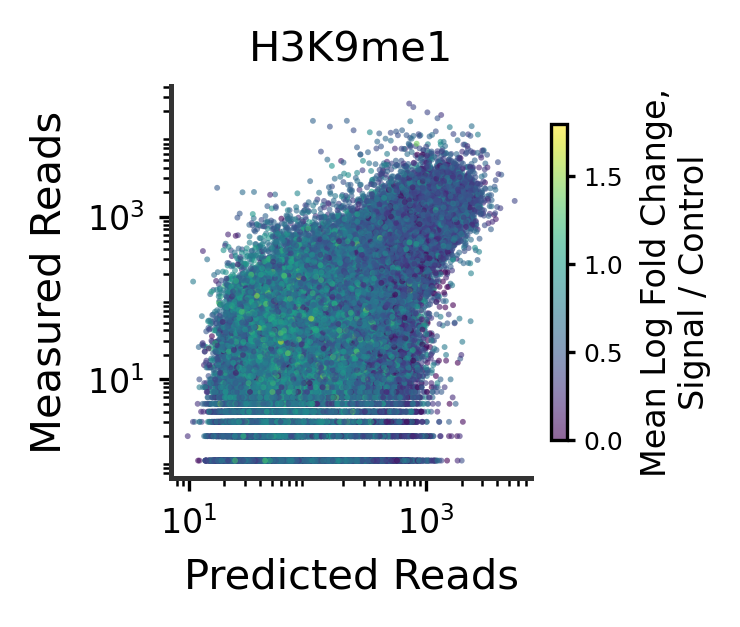

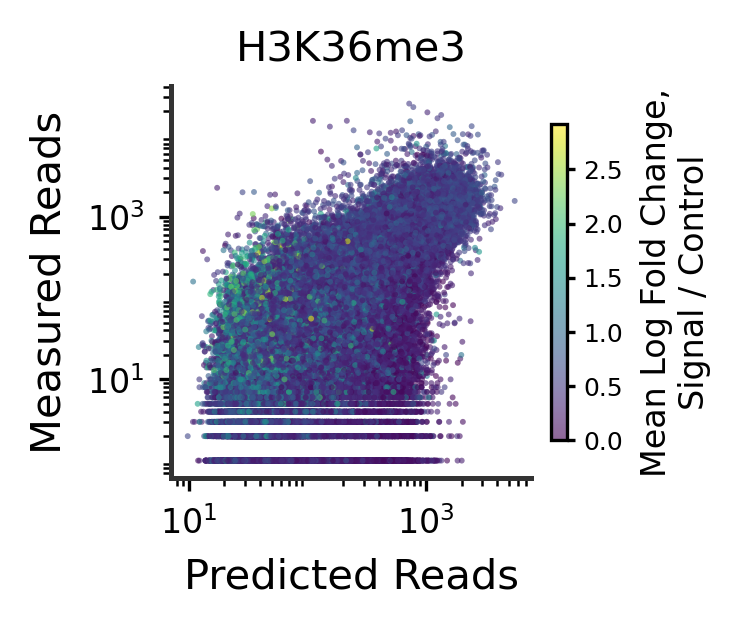

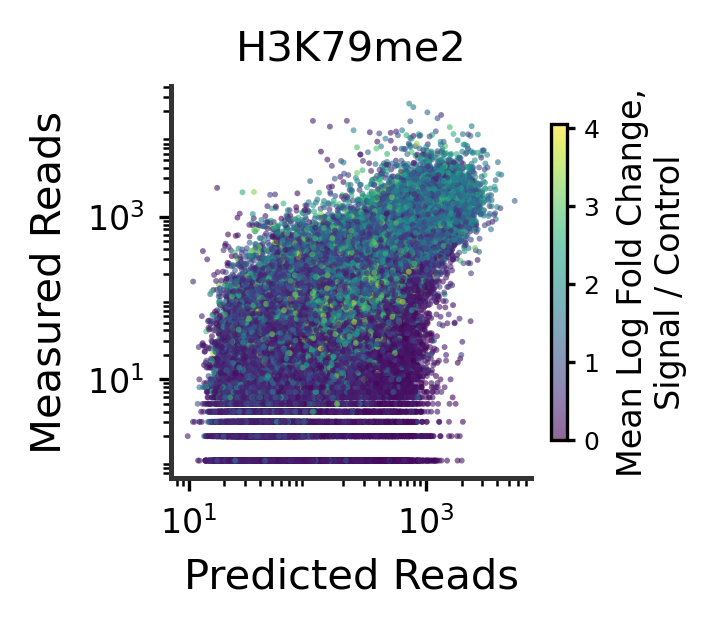

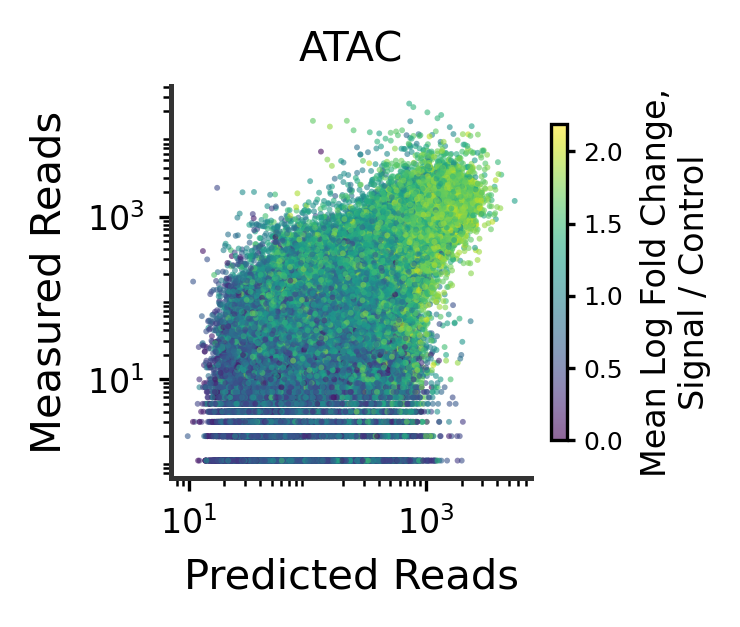

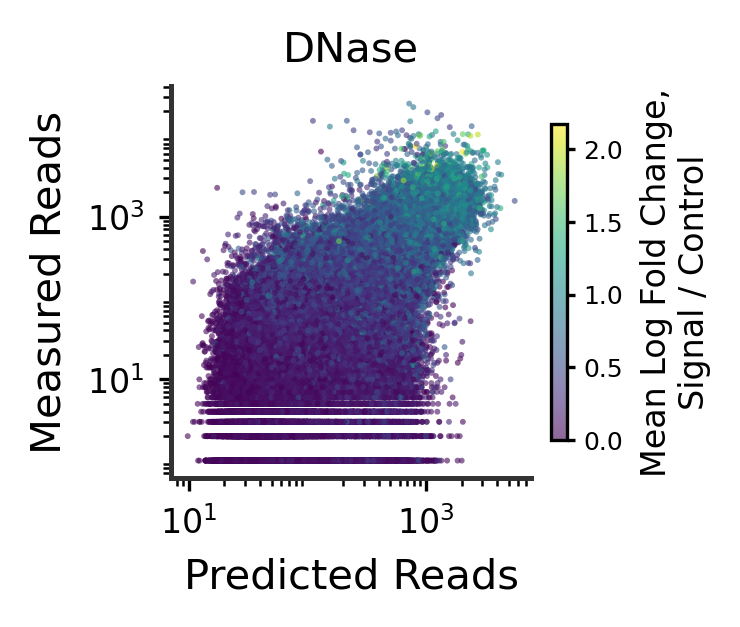

In [199]:
from matplotlib import pyplot as plt, ticker as mticker


def plot_pred_vs_true_counts_by_chromatin_data(pred_logcounts, true_counts, color_by, title=None, save_path=None):
    
    plt.figure(figsize=(1.7, 1.7), dpi=300)
    
    # if the model preds/data are stranded, merge the two strands
    if len(pred_logcounts.shape) > 1:
        pred_logcounts = np.sum(pred_logcounts, axis=-1)
    if len(true_counts.shape) > 1:
        true_counts = np.sum(true_counts, axis=-1)
    assert pred_logcounts.shape == true_counts.shape

    plt.scatter(np.exp(pred_logcounts), true_counts,
                    alpha = 0.6, s = 2, c = color_by, linewidths=0)

    plt.semilogx()
    plt.semilogy()

    plt.ylabel("Measured Reads", fontsize=10)
    plt.xlabel("Predicted Reads", fontsize=10)
    
    if title is not None:
        plt.title(title, fontsize=10)

    # aesthetics
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params("both", length=3, labelsize=8)
    
    ax.set_xticks([10, 1000])
    ax.set_yticks([10, 1000])
    ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    #ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
        
    cb = plt.colorbar(fraction=0.04)
    cb.set_label(label=r'Mean Log Fold Change,' + "\nSignal / Control",
                 size=8)
    cb.ax.tick_params(labelsize=6, length=2, pad=2)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.04, dpi = 300)
    
    plt.show()
    

for name, chrom_data in union_chromatin_data_mean["K562"].items():
    save_path = figures_dir + "celltypes_histone_scatter_K562_union_" + name + ".png"
    
    plot_pred_vs_true_counts_by_chromatin_data(union_pred_logcounts["K562"],
                                               union_true_counts["K562"],
                                               chrom_data, title = name,
                                               save_path = save_path)

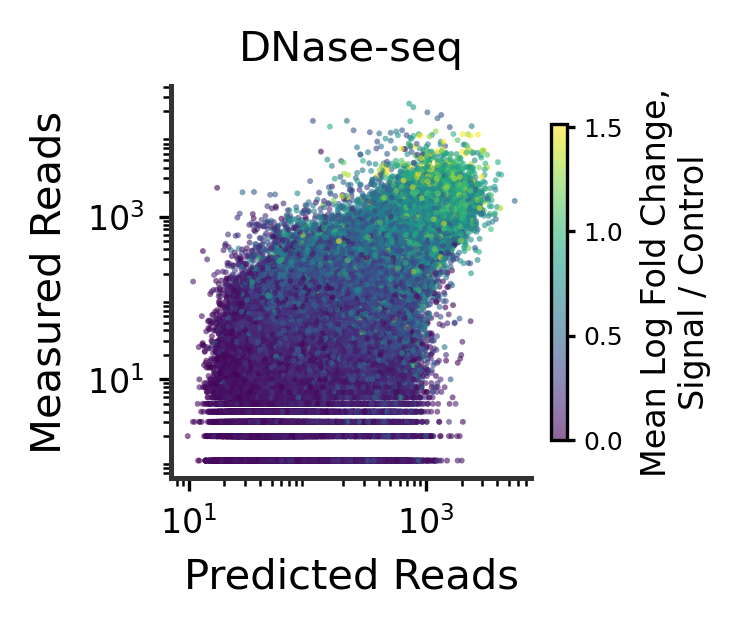

In [200]:
# buncha high outliers in the DNase data, so clip

for name, chrom_data in union_chromatin_data_mean["K562"].items():
    if name != "DNase":
        continue
        
    chrom_data_clip_to = sorted(chrom_data)[-100]
    chrom_data2 = chrom_data.copy()
    chrom_data2[chrom_data2 > chrom_data_clip_to] = chrom_data_clip_to
    plot_pred_vs_true_counts_by_chromatin_data(union_pred_logcounts["K562"],
                                               union_true_counts["K562"],
                                               chrom_data2, title = name + "-seq",
                        save_path = figures_dir + "celltypes_histone_scatter_K562_union_" + name + ".png")

## Linear Models of PRO-cap Using Chromatin Info

In [80]:
from sklearn.metrics import r2_score
import statsmodels.api as sm


def _fit_model_get_rsquared(to_predict, predictor_array, fold_labels,
                            predictor_names = None):
    
    if len(predictor_array.shape) == 1:
        predictor_array = predictor_array[:, None]
        
    assert predictor_array.shape[0] == len(to_predict), (predictor_array.shape[0], len(to_predict))
    
    to_predict = to_predict.squeeze()[:, None]
    assert to_predict.shape == (len(to_predict), 1), to_predict.shape
    
    if predictor_names is not None:
        assert len(predictor_names) == predictor_array.shape[1], (len(predictor_names), predictor_array.shape[1])
    else:
        predictor_names = ["col" + str(i) for i in range(predictor_array.shape[1])]
        
    model_formula = "y ~ " + " + ".join(predictor_names)
    
    if len(predictor_names) > 1:
        # if there are multiple predictors, generate second-order terms for them
        second_order_terms = itertools.combinations(predictor_names, 2)
        
        for term_part1, term_part2 in second_order_terms:
            model_formula = model_formula + " + " + term_part1 + ":" + term_part2
        
    colnames = ["y"] + predictor_names
    fold_rsquareds = []
    for fold_i in range(len(FOLDS)):
        assert len(to_predict) == len(fold_labels), (len(to_predict), len(fold_labels))
        assert len(predictor_array) == len(fold_labels), (len(predictor_array), len(fold_labels))
        
        to_predict_train = to_predict[fold_labels != fold_i]
        to_predict_test = to_predict[fold_labels == fold_i]
        predictor_array_train = predictor_array[fold_labels != fold_i]
        predictor_array_test = predictor_array[fold_labels == fold_i]
        
        df_train = pd.DataFrame(np.concatenate((to_predict_train, predictor_array_train), axis=1),
                                columns=colnames)
        df_train = sm.add_constant(df_train)
        
        model = smf.ols(formula=model_formula, data=df_train)
        fit_model = model.fit()

        df_test = pd.DataFrame(predictor_array_test, columns=colnames[1:])
        df_test = sm.add_constant(df_test)
        
        test_preds = fit_model.predict(sm.add_constant(df_test))
        
        rsquared_raw = r2_score(to_predict_test, test_preds)
        adj_factor = (len(predictor_array_test) - 1) / (len(predictor_array_test) - len(predictor_names) - 1)
        rsquared_adj = 1 - (1 - rsquared_raw) * adj_factor
    
        fold_rsquareds.append(rsquared_adj)

    return np.mean(fold_rsquareds)


def calc_rsquared(target_cell, source_cell=None, chromatin_info_to_use=None,
                  union_peaks=True):
    
    assert source_cell is not None or chromatin_info_to_use is not None
    
    if union_peaks:
        chromatin_data_mean = union_chromatin_data_mean
        _pred_logcounts = union_pred_logcounts
        _true_counts = union_true_counts
    else:
        chromatin_data_mean = K562_chromatin_data_mean
        _pred_logcounts = {"K562" : K562_peaks_pred_logcounts}
        _true_counts = {"K562" : K562_peaks_true_counts}
        
    
    predictors = []
    if source_cell is not None:
        # include predictions from ProCapNet trained in the source cell type
        predictors.append(_pred_logcounts[source_cell])
    
    if chromatin_info_to_use is not None:
        if type(chromatin_info_to_use) == str:
            # load just one chomatin dataset to include in the model
            predictors.append(chromatin_data_mean[target_cell][chromatin_info_to_use])
        else:
            assert type(chromatin_info_to_use) == list, chromatin_info_to_use
            # load all chromatin datasets to include in the model
            for chromatin_name in chromatin_info_to_use:
                predictors.append(chromatin_data_mean[target_cell][chromatin_name])
            predictors = [data for data in predictors if not np.any(np.isnan(data))]
    
    predictors = np.array(predictors).T

    to_predict = np.log1p(_true_counts[target_cell])
    
    if union_peaks:
        _fold_labels = np.array(fold_labels_union_peaks)
    else:
        _fold_labels = np.array(fold_labels[target_cell])
    
    return _fit_model_get_rsquared(to_predict, predictors, fold_labels=_fold_labels)

In [81]:
def calc_pcn_only_rsquareds(cell_types_to_use = cell_types_with_data, union_peaks=True):
    pcn_only_rsquareds = defaultdict(lambda : [])
    
    # not symmetric, so actually do each pair twice
    for target_cell in cell_types_to_use:
        for source_cell in cell_types_to_use:
            if target_cell == source_cell:
                continue
            
            # get r-squared from fitting a linear model from
            # source-cell ProCapNet predictions to target-cell PRO-cap
            
            rsquared = calc_rsquared(target_cell, source_cell=source_cell,
                                     chromatin_info_to_use=None, union_peaks=union_peaks)
            pcn_only_rsquareds["cross"].append(rsquared)
            
        # also get r-squared for fitting a linear model within each cell type
        
        rsquared = calc_rsquared(target_cell, source_cell=target_cell,
                                 chromatin_info_to_use=None, union_peaks=union_peaks)
        pcn_only_rsquareds["same"].append(rsquared)
                
    return pcn_only_rsquareds

                        
all_union_peak_rsquareds = {"procapnet_only" : calc_pcn_only_rsquareds()}
K562_union_peak_rsquareds = {"procapnet_only" : calc_pcn_only_rsquareds(cell_types_to_use = ["K562"])}
K562_peak_rsquareds = {"procapnet_only" : calc_pcn_only_rsquareds(cell_types_to_use = ["K562"], union_peaks=False)}

In [82]:
all_union_peak_rsquareds["procapnet_only"]

defaultdict(<function __main__.calc_pcn_only_rsquareds.<locals>.<lambda>()>,
            {'cross': [0.33053454010991545,
              0.37513743864455484,
              0.3035543013434017,
              0.4119110084509871,
              0.3191798210585106,
              0.3319420487386367,
              0.43404836343691083,
              0.31086958916537893,
              0.3186959633300159,
              0.47210825588094024,
              0.4144517304986834,
              0.4257845782051221],
             'same': [0.447819802113464,
              0.4936636462824803,
              0.5444276409194363,
              0.46906454969545563]})

In [83]:
def calc_combo_rsquareds(cell_types_to_use = cell_types_with_data,
                         chromatin_data_names = chromatin_data_names,
                         include_same_cell = False, union_peaks=True):
    rsquareds = defaultdict(lambda : defaultdict(lambda : dict()))
    rsquareds["all_chromatin_plus_procapnet"] = []
    rsquareds["all_chromatin"] = []
    
    for target_cell in cell_types_to_use:
        for source_cell in cell_types_to_use:
            if not include_same_cell:
                if target_cell == source_cell:
                    continue
                    
            # iterate through all individual chromatin datasets,
            # fit a model and get rsquared for predicting target-cell PRO-cap
            # using target-cell chromatin data and source-cell ProCapNet preds
            
            for chromatin_name in chromatin_data_names:
                cell_combo = target_cell + "," + source_cell
                
                # the one dataset awkwardly missing from Roadmap
                if "CACO2" in cell_combo and chromatin_name == "H3K27ac":
                    continue

                rsquared = calc_rsquared(target_cell, source_cell=source_cell,
                                         chromatin_info_to_use=chromatin_name,
                                         union_peaks=union_peaks)
                
                rsquareds["single_chromatin_plus_procapnet"][cell_combo][chromatin_name] = rsquared
            
            # repeat but for a model that uses ALL the target-cell chromatin data at once
                
            rsquared = calc_rsquared(target_cell, source_cell=source_cell,
                                     chromatin_info_to_use=chromatin_data_names,
                                     union_peaks=union_peaks)
            rsquareds["all_chromatin_plus_procapnet"].append(rsquared)
            
            
        # now do the same, but without ProCapNet predictions included

        # iterate through all individual chromatin datasets,
        # fit a model and get rsquared for predicting target-cell PRO-cap
        # using target-cell chromatin data WITHOUT any source-cell ProCapNet preds
        
        for chromatin_name in chromatin_data_names:
            # the one dataset awkwardly missing from Roadmap
            if target_cell == "CACO2" and chromatin_name == "H3K27ac":
                continue

            rsquared = calc_rsquared(target_cell, source_cell=None,
                                     chromatin_info_to_use=chromatin_name,
                                     union_peaks=union_peaks)
            rsquareds["single_chromatin"][target_cell][chromatin_name] = rsquared
            
        # finally, repeat with ALL target-cell chromatin data (no ProCapNet preds)
            
        rsquared = calc_rsquared(target_cell, source_cell=None,
                                 chromatin_info_to_use=chromatin_data_names,
                                 union_peaks=union_peaks)
        rsquareds["all_chromatin"].append(rsquared)
                    
    return rsquareds


all_union_peak_rsquareds.update(calc_combo_rsquareds())
K562_union_peak_rsquareds.update(calc_combo_rsquareds(cell_types_to_use=["K562"],
                                                      chromatin_data_names = K562_chromatin_data_names,
                                                      include_same_cell=True))
K562_peak_rsquareds.update(calc_combo_rsquareds(cell_types_to_use=["K562"],
                                                chromatin_data_names = K562_chromatin_data_names,
                                                include_same_cell=True,
                                                union_peaks=False))

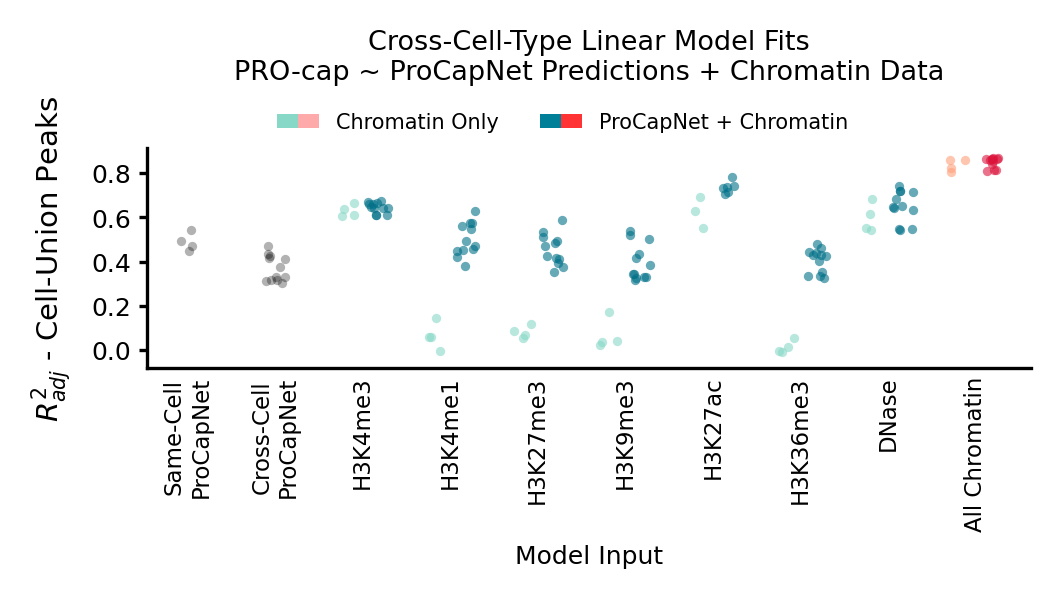

In [142]:
# drawing two colors in one legend entry: 
# https://stackoverflow.com/questions/31908982/multi-color-legend-entry

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)
        handlebox.add_artist(patch)
        return patch


def plot_improvement_from_chromatin_dots(all_rsquareds, save_path = None):
    plt.figure(figsize=(3.8,0.95), dpi=300)
    
    jitter_by = 0.12
    group_offset = 0.35
    
    chrom_names = chromatin_data_names
    
    # plot rsquareds from just ProCapNet predictions vs. observed PRO-cap
    
    first_two_cols = [all_rsquareds["procapnet_only"]["same"],
                      all_rsquareds["procapnet_only"]["cross"]]
    for x_axis_i, y_vals in enumerate(first_two_cols):
        dots = plt.scatter([x_axis_i] * len(y_vals), y_vals,
                           s=5, color="k", alpha=0.3, linewidth=0) 
        jitter_dots(dots, jitter_by=jitter_by, along_y=False)
    
    
    
    x_offsets = [- group_offset * 0.5 + 2,
                   group_offset * 0.5 + 2]
    rsquareds_to_plot = [all_rsquareds["single_chromatin"],
                         all_rsquareds["single_chromatin_plus_procapnet"]]
    colors = ["#87d8c7", "#007088", "royalblue", "navy"]
    
    for x_offset, rsquareds_group, color in zip(x_offsets, rsquareds_to_plot, colors):
        # put data in format to add dots to plot in groups
        to_plot = [[] for _ in range(len(chrom_names))]
        for cell_combo, inner_dict in rsquareds_group.items():
            for i, chrom_name in enumerate(chrom_names):
                if chrom_name in inner_dict.keys():
                    to_plot[i].append(inner_dict[chrom_name])

        for x_val, y_vals in enumerate(to_plot):
            dots = plt.scatter([x_val + x_offset] * len(y_vals), y_vals,
                               s=5, color=color, alpha=0.6, linewidth=0)
            jitter_dots(dots, jitter_by=jitter_by, along_y=False)
           
    
    rsquareds_to_plot_end = [all_rsquareds["all_chromatin"],
                             all_rsquareds["all_chromatin_plus_procapnet"]]
    colors = ["lightsalmon", "crimson"]
    
    for x_offset, rsquareds_group, color in zip(x_offsets, rsquareds_to_plot_end, colors):
        dots = plt.scatter([len(chrom_names) + x_offset] * len(rsquareds_group),
                           rsquareds_group,
                           s=5, color=color, alpha=0.6, linewidth=0) 
        jitter_dots(dots, jitter_by=jitter_by, along_y=False)
        
        
    plt.ylim(-0.08, plt.gca().get_ylim()[1])
        
    xticks = ["Same-Cell\nProCapNet", "Cross-Cell\nProCapNet"]
    xticks += [name for name in chrom_names]
    xticks += ["All Chromatin"]
    
    plt.xticks(range(len(xticks)), xticks,
               rotation=90, fontsize=5.5)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8])
        
    plt.ylabel(r'$R_{adj}^2$' + " - Cell-Union Peaks", fontsize=7)
    plt.xlabel("Model Input", fontsize=6, labelpad=3)
    plt.title("Cross-Cell-Type Linear Model Fits\nPRO-cap ~ ProCapNet Predictions + Chromatin Data",
              fontsize=6.5, y=1.2)
    
    ax = plt.gca()
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params("x", length=0, pad=2)
    ax.tick_params("y", length=2, pad=2, labelsize=6)
    
    
    legend_elements = [MulticolorPatch(['#87d8c7', '#FFAAAA']),
                       MulticolorPatch(['#008098', '#FF3333'])]

    ax.legend(handles = legend_elements,
              labels = ['Chromatin Only', 'ProCapNet + Chromatin'],
              handler_map={MulticolorPatch: MulticolorPatchHandler()},
              frameon=False, fontsize=5, ncol=3,
              bbox_to_anchor=(0.47, 1.25), loc='upper center')
    
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.001, dpi = 300)

    plt.show()
        
plot_improvement_from_chromatin_dots(all_union_peak_rsquareds,
                                     save_path = figures_dir + "celltypes_cross_cell_rsquareds.png")

In [113]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def double_bar_plot(rsquareds, ylabel = r'$R_{adj}^2$',
                    chrom_names = K562_chromatin_data_names,
                    save_path=None):

    plt.figure(figsize=(3.2,0.9), dpi=300)
    
    bar_offset = 0.4
        
    to_plot = [rsquareds["single_chromatin"]["K562"][name] for name in chrom_names]
    plt.bar(np.arange(len(to_plot)) - bar_offset / 2, to_plot, color="#87d8c7", width=bar_offset)
    
    to_plot = [rsquareds["single_chromatin_plus_procapnet"]["K562,K562"][name] for name in chrom_names]
    plt.bar(np.arange(len(to_plot)) + bar_offset / 2, to_plot, color="#008098", width=bar_offset)

    plt.title("Linear PRO-cap Models\nPRO-cap ~ ProCapNet Predictions + Chromatin Data", fontsize=6.5, y=1.05)
    plt.ylabel(ylabel, fontsize=6)
    plt.xlabel("Model Input", fontsize=6, labelpad=8)
    
    plt.xticks(range(len(chrom_names)), chrom_names)

    ax = plt.gca()
    #ax.spines[["left","bottom"]].set_linewidth(1.2)
    ax.spines[["left","bottom"]].set_color("#333333")
    ax.spines[["top","right"]].set_visible(False)
    ax.tick_params("y", length=2, pad=2, labelsize=5)
    ax.tick_params("x", length=0, rotation=90, labelsize=5.5)

    lower_hline = rsquareds["procapnet_only"]["same"][0]
    plt.hlines(lower_hline, -0.5, len(chrom_names) - 0.5,
               linestyle="dashed", color="k", linewidth=1, alpha=0.2, zorder=0)

    upper_hline = rsquareds["all_chromatin_plus_procapnet"][0]
    plt.hlines(upper_hline, -0.5, len(chrom_names) - 0.5,
               linestyle="dotted", color="red", linewidth=1, alpha=0.8)

    plt.xlim(-0.7, len(chrom_names) - 0.4)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8])

    legend_elements = [Line2D([0], [0], color='k', linestyle="dashed",
                              alpha=0.3, lw=1, label='ProCapNet Only'),
                       Line2D([0], [0], color='red', linestyle="dotted",
                              alpha=0.8, lw=1, label='ProCapNet + All'),
                       Patch(facecolor='#87d8c7', label='Chromatin Only'),
                       Patch(facecolor='#008098', label='ProCapNet + Chromatin')]

    ax.legend(handles=legend_elements, frameon=False, fontsize=6.5, ncol=2,
              bbox_to_anchor=(0.47, -0.95), loc='upper center')
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.04, dpi = 300)

    plt.show()

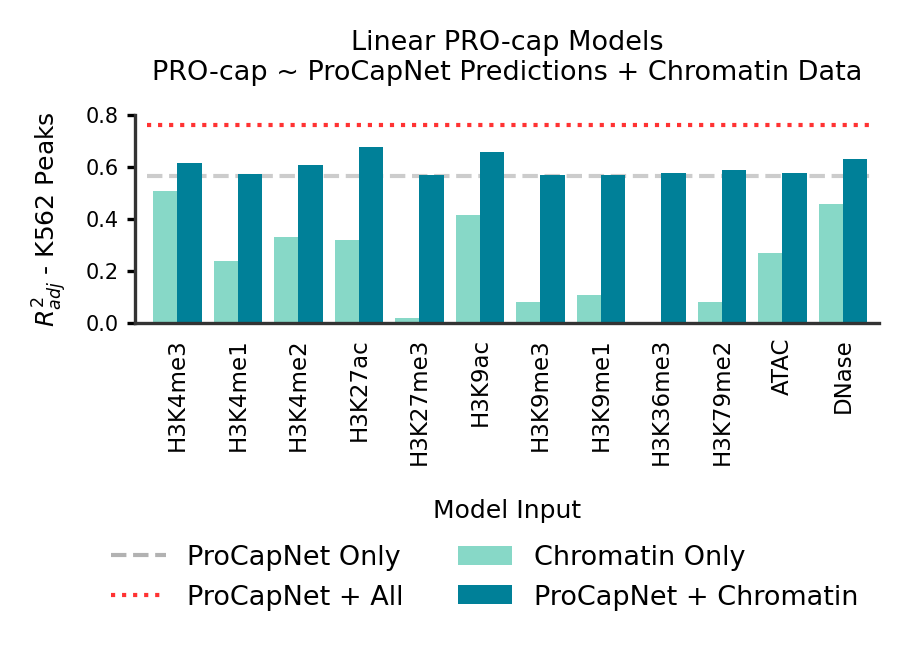

In [114]:
double_bar_plot(K562_peak_rsquareds, ylabel = r'$R_{adj}^2$' + " - K562 Peaks",
                save_path = figures_dir + "celltypes_K562_linear_rsquared.png")

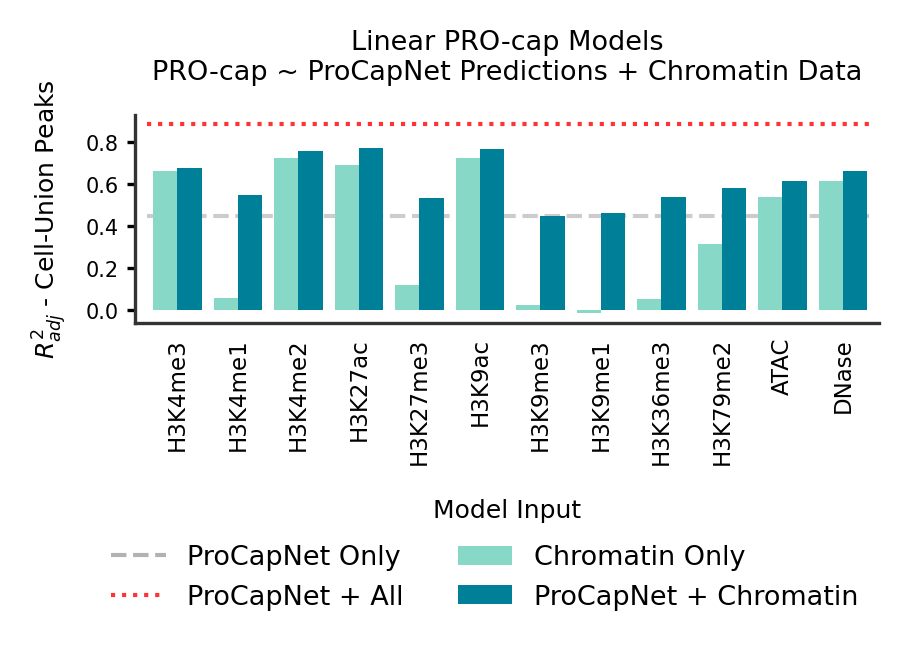

In [115]:
double_bar_plot(K562_union_peak_rsquareds, ylabel = r'$R_{adj}^2$' + " - Cell-Union Peaks",
                save_path = figures_dir + "celltypes_K562_union_linear_rsquared.png")

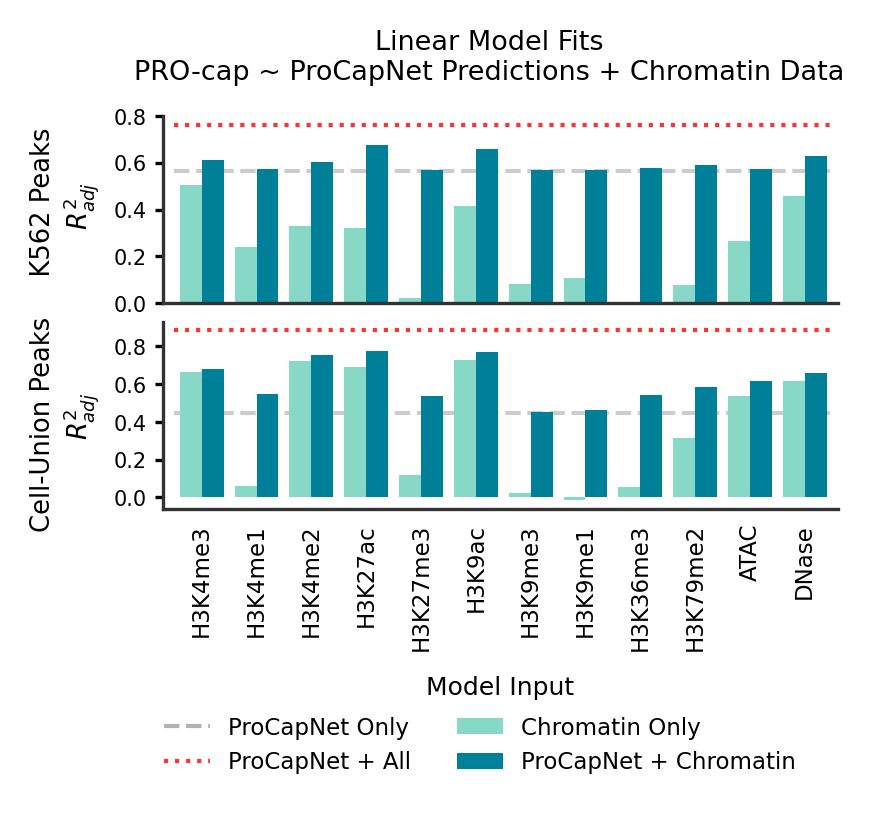

In [149]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


def double_double_bar_plot(rsquareds_K562, rsquareds_union,
                    chrom_names = K562_chromatin_data_names,
                    save_path=None):

    fig, axes = plt.subplots(2, figsize=(2.9,1.7), dpi=300)
    
    bar_offset = 0.4
    
    ylabels = ["  K562 Peaks\n " + r'$R_{adj}^2$', "Cell-Union Peaks  \n" + r'$R_{adj}^2$ ']
    
    for ax_i, (ax, rsquareds) in enumerate(zip(axes, [rsquareds_K562, rsquareds_union])):

        to_plot = [rsquareds["single_chromatin"]["K562"][name] for name in chrom_names]
        ax.bar(np.arange(len(to_plot)) - bar_offset / 2, to_plot, color="#87d8c7", width=bar_offset)

        to_plot = [rsquareds["single_chromatin_plus_procapnet"]["K562,K562"][name] for name in chrom_names]
        ax.bar(np.arange(len(to_plot)) + bar_offset / 2, to_plot, color="#008098", width=bar_offset)

        lower_hline = rsquareds["procapnet_only"]["same"][0]
        ax.hlines(lower_hline, -0.5, len(chrom_names) - 0.5,
                   linestyle="dashed", color="k", linewidth=1, alpha=0.2, zorder=0)

        upper_hline = rsquareds["all_chromatin_plus_procapnet"][0]
        ax.hlines(upper_hline, -0.5, len(chrom_names) - 0.5,
                   linestyle="dotted", color="red", linewidth=1, alpha=0.8)

        # aesthetics
        
        ax.set_ylabel(ylabels[ax_i], fontsize=6.2, labelpad=3)
        
        ax.set_xlim(-0.7, len(chrom_names) - 0.4)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
        
        ax.spines[["left","bottom"]].set_color("#333333")
        ax.spines[["top","right"]].set_visible(False)
        ax.tick_params("y", length=2, pad=2, labelsize=5)
        ax.tick_params("x", length=0, rotation=90, labelsize=5.5)
        
    axes[0].set_xticks([])
    axes[-1].set_xticks(range(len(chrom_names)), chrom_names)
    axes[-1].set_xlabel("Model Input", fontsize=6, labelpad=6)
        
    plt.suptitle("Linear Model Fits\nPRO-cap ~ ProCapNet Predictions + Chromatin Data",
                 fontsize=6.5, y=1.05)
        
    legend_elements = [Line2D([0], [0], color='k', linestyle="dashed",
                              alpha=0.3, lw=1, label='ProCapNet Only'),
                       Line2D([0], [0], color='red', linestyle="dotted",
                              alpha=0.8, lw=1, label='ProCapNet + All'),
                       Patch(facecolor='#87d8c7', label='Chromatin Only'),
                       Patch(facecolor='#008098', label='ProCapNet + Chromatin')]

    ax.legend(handles=legend_elements, frameon=False, fontsize=5.5, ncol=2,
              bbox_to_anchor=(0.47, -1), loc='upper center')
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.04, dpi = 300)

    fig.subplots_adjust(hspace=0.1)
        
    plt.show()
    
    
double_double_bar_plot(K562_peak_rsquareds, K562_union_peak_rsquareds,
                        save_path = figures_dir + "celltypes_rsquareds_double_double_bar.png")